# Trust and Attitudes toward Migrants in West and East Germany

### Research Questions:
+ Are attitudes towards migrants associated with trust in Germany?
+ How stable is the association between trust and attitude towards migrants within the generation? Is there a difference between the Western and Eastern regions of Germany?


### Plan:
1. Data preprocessing
2. Descriptive analysis
3. Correlation analysis (Are attitudes towards migrants associated with trust in Germany?)
    3.1. Check independence with chi-square test and Cramer`s V
    3.2. Check the strength with Logreg model
4. Test the stability of association
    4.1. Create age cohorts
    4.2. Test the stability

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.formula.api import logit
from scipy.stats import chi2_contingency
from dython.nominal import identify_nominal_columns
from dython.nominal import associations

In [42]:
wvs_full = pd.read_csv('WVS_TimeSeries_4_0 2.csv')

## 1. Data preprocessing

In [43]:
#Выбираем из датасета данные для Германии (276)
wvs_ger = wvs_full[wvs_full["S003"] == 276]

In [44]:
#Выбираем нужные колонки
wvs_ger = wvs_ger[['X048ISO', 'S024', 'X025R', 'X001', 'X003R', 'X028', 'A165', 'Y014A', 'Y014B','Y014C', 'A124_06', 'C002', 'X002' ]]

Выбираем необходимые для анализа переменные:
'X048ISO' = Region ISO 3166-2
'S024' = Country - wave
'X025R' = Education level (recoded)
'X001' = Sex
'X003R' = Age (6 intervals)
'X028' = Employment status
'A165' = Most people can be trusted
'Y014A' = TRUSTARMY- Welzel scepticism- 1: Inverse trust in army
'Y014B' = TRUSTPOLICE- Welzel scepticism- 2: Inverse trust in police
'Y014C' = TRUSTCOURTS- Welzel scepticism- 3: Inverse trust in courts
'A124_06' = Neighbours: Immigrants/foreign workers - Could you please mention any that you would not like to have as
neighbors?
'C002' = Jobs scarce: Employers should give priority to (nation) people than immigrants (3 categories)

In [45]:
#Переименуем колонки
wvs_rename_dict={'X048ISO' : 'Region',
                    'S024' : 'Wave',
                    'X025R' : 'Edu',
                    'X001' : 'Sex',
                    'X003R' : 'Age_group',
                    'X028' : 'Employment',
                    'A165' : 'Gen_trust',
                    'Y014A' : 'TRUSTARMY',
                    'Y014B' : 'TRUSTPOLICE',
                    'Y014C' : 'TRUSTCOURTS',
                    'A124_06' : 'Neighbours_immigrants_attitudes',
                    'C002' : 'Jobs_priority_to_nation',
                    'X002' : 'Year_birth'}
wvs = wvs_ger.rename(columns=wvs_rename_dict)

In [46]:
#Убираем ответы -5:Missing; Unknown, -4:Not asked in survey, -3:Not applicable, -2:No answer, -1:Don´t know, -99-.- Missing. Убранные значения сокращают датасет на 13%, но значительно упрощают анализ.
values_to_delete = [-1,-2,-3,-4,-5,-99]

condition1 = wvs['Edu'].isin(values_to_delete)
condition2 = wvs['Sex'].isin(values_to_delete)
condition3 = wvs['Age_group'].isin(values_to_delete)
condition4 = wvs['Employment'].isin(values_to_delete)
condition5 = wvs['Gen_trust'].isin(values_to_delete)
condition6 = wvs['TRUSTARMY'].isin(values_to_delete)
condition7 = wvs['TRUSTPOLICE'].isin(values_to_delete)
condition8 = wvs['TRUSTCOURTS'].isin(values_to_delete)
condition9 = wvs['Neighbours_immigrants_attitudes'].isin(values_to_delete)
condition10 = wvs['Jobs_priority_to_nation'].isin(values_to_delete)
condition11 = wvs['Year_birth'].isin(values_to_delete)

wvs_filtered = wvs[~(condition1 | condition2 | condition3 | condition4 | condition5 | condition6 | condition7 | condition8 | condition9 | condition10 |condition11)]


In [47]:
wvs_filtered.reset_index(drop=True)

,Region,Wave,Edu,Sex,Age_group,Employment,Gen_trust,TRUSTARMY,TRUSTPOLICE,TRUSTCOURTS,Neighbours_immigrants_attitudes,Jobs_priority_to_nation,Year_birth
0,276015,2765,2,2,5,4,2,0.33,0.33,1.00,0,1,1945
1,276015,2765,2,2,1,6,1,0.66,0.33,1.00,0,1,1982
2,276015,2765,1,2,4,1,2,1.00,0.66,0.66,0,1,1957
3,276015,2765,1,1,4,1,2,0.66,0.33,NaN,0,1,1960
4,276015,2765,1,2,4,1,2,1.00,0.66,NaN,0,1,1956
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7144,276010,2767,2,1,2,6,1,0.00,0.00,0.33,0,1,1991
7145,276010,2767,1,2,4,1,1,0.66,0.33,0.33,0,2,1965
7146,276010,2767,3,2,4,1,2,0.33,0.00,0.00,0,1,1972
7147,276010,2767,2,1,6,4,2,1.00,0.66,0.00,0,1,1938


Recode variables
Waves:
2762:Germany (2) = Wave 2
2763:Germany (3) = Wave 3
2764:Germany (4) = Wave 4
2765:Germany (5) = Wave 5
2766:Germany (6) = Wave 6
2767:Germany (7) = Wave 7

Regions:
276001 DE-BW Baden-Württemberg = West Germany = 0
276002 DE-BY Bavaria = West Germany = 0
276003 DE-BE Berlin = West Germany = 0
276004 DE-BB Brandenburg = East Germany = 1
276005 DE-HB Bremen = West Germany = 0
276006 DE-HH Hamburg = West Germany = 0
276007 DE-HE Hesse = West Germany = 0
276008 DE-MV Mecklenburg-Western Pomerania = East Germany = 1
276009 DE-NI Lower Saxony = West Germany = 0
276010 DE-NW North Rhine-Westphalia = West Germany = 0
276011 DE-RP Rhineland-Palatinate = West Germany = 0
276012 DE-SL Saarland = West Germany = 0
276013 DE-SN Saxony = East Germany = 1
276014 DE-ST Saxony-Anhalt = East Germany = 1
276015 DE-SH Schleswig-Holstein = West Germany = 0
276016 DE-TH Thuringia = East Germany = 1

In [48]:
#Перекодируем значения переменных Region, разделив на регионы Западной Германии (900) и Восточной Германии (901)
replace_dict = {276004: 901, 276008: 901, 276013: 901, 276014: 901, 276016: 901, 276001:900, 276002:900, 276003:900, 276005:900, 276006:900, 276007:900, 276009:900, 276010:900, 276011:900, 276012:900, 276015:900,}
wvs_filtered['Region'] = wvs_filtered['Region'].replace(replace_dict)

<ipython-input-48-7cabf2da6331>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wvs_filtered['Region'] = wvs_filtered['Region'].replace(replace_dict)


In [49]:
#Перекодируем значения переменной Wave
replace_dict = {2762:2, 2763:3, 2764:4, 2765:5, 2766:6, 2767:7}
wvs_filtered['Wave'] = wvs_filtered['Wave'].replace(replace_dict)

<ipython-input-49-c57edd886d6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wvs_filtered['Wave'] = wvs_filtered['Wave'].replace(replace_dict)


In [50]:
#Избавимся от NA
wvs_filtered = wvs_filtered.dropna()

In [51]:
#Копия датасета, будем использовать для создания heatmap
wvs_filtered_2 = wvs_filtered.copy()

In [52]:
#Перекодирую переменные так, чтобы увеличение значения отражало положительный эффект. Это позволит нагляднее воспринимать графики

wvs_filtered['Gen_trust'] = wvs_filtered['Gen_trust'].replace({2: 0})
wvs_filtered['Sex'] = wvs_filtered['Sex'].replace({1: 0, 2:1})
wvs_filtered['Neighbours_immigrants_attitudes'] = wvs_filtered['Neighbours_immigrants_attitudes'].replace({1:0, 0:1})
wvs_filtered['Jobs_priority_to_nation'] = wvs_filtered['Jobs_priority_to_nation'].replace({2: 0, 3: 0.5})
wvs_filtered['Region'] = wvs_filtered['Region'].replace({900: 0, 901: 1})
wvs_filtered['TRUSTCOURTS'] = wvs_filtered['TRUSTCOURTS'].replace({0 : 1, 0.33 : 0.66, 0.66 : 0.33, 1 : 0})
wvs_filtered['TRUSTPOLICE'] = wvs_filtered['TRUSTPOLICE'].replace({0 : 1, 0.33 : 0.66, 0.66 : 0.33, 1 : 0})
wvs_filtered['TRUSTARMY'] = wvs_filtered['TRUSTARMY'].replace({0 : 1, 0.33 : 0.66, 0.66 : 0.33, 1 : 0})

In [53]:
codebook_new = pd.read_excel('Codebook_new.xlsx')
codebook_new

,Region,Education level (recoded),Sex,Age (6 intervals),Employment status,Most people can be trusted,TRUSTARMY- Welzel scepticism- 1: Inverse trust in army,TRUSTPOLICE- Welzel scepticism- 2: Inverse trust in police,TRUSTCOURTS- Welzel scepticism- 3: Inverse trust in courts,Attitides towards migrants as neighbours,Jobs scarce: Employers should give priority to (nation) people than immigrants (3 categories)
0,East Germany,1:Lower,Male,1:15-24,1:Full time,0 - No,0.- Very low,0.- Very low,0.- Very low,0 - Negative,Agree
1,West Germany,2:Middle,Female,2:25-34,2:Part time,1 - Yes,0.33.- Low,0.33.- Low,0.33.- Low,1 - Positive,Disagree
2,NaN,3:Upper,NaN,3:35-44,3:Self employed,NaN,0.66.- High,0.66.- High,0.66.- High,NaN,Neither
3,NaN,NaN,NaN,4:45-54,4:Retired,NaN,1.- Very high,1.- Very high,1.- Very high,NaN,NaN
4,NaN,NaN,NaN,5:55-64,5:Housewife,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,6:65 and more years,6:Students,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,7:Unemployed,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,8:Other,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Descriptive analysis

In [54]:
df_for_plot = wvs_filtered.copy()

In [55]:
df_for_plot.sample(20)

,Region,Wave,Edu,Sex,Age_group,Employment,Gen_trust,TRUSTARMY,TRUSTPOLICE,TRUSTCOURTS,Neighbours_immigrants_attitudes,Jobs_priority_to_nation,Year_birth
129950,0,6,1,0,5,1,1,0.66,0.66,0.66,0,0.0,1953
130312,1,6,2,1,1,1,0,0.00,0.00,0.00,1,0.5,1990
126404,1,5,2,1,1,1,1,0.66,0.66,0.00,1,0.0,1984
128063,0,3,2,1,2,7,1,0.00,0.66,0.66,1,1.0,1969
130982,0,6,2,1,4,4,0,0.00,0.33,0.33,1,0.0,1967
129509,1,6,2,1,5,7,0,0.33,0.66,0.66,1,0.0,1954
125758,0,5,2,1,2,7,1,0.33,0.33,0.33,1,0.0,1979
129096,1,3,3,1,3,2,0,0.33,0.33,0.66,1,0.0,1960
129566,0,6,2,1,3,5,0,0.66,0.33,0.66,1,0.0,1977
132568,0,7,3,1,5,1,0,0.00,0.66,0.33,1,0.0,1960


In [56]:
df_for_plot.describe()

,Region,Wave,Edu,Sex,Age_group,Employment,Gen_trust,TRUSTARMY,TRUSTPOLICE,TRUSTCOURTS,Neighbours_immigrants_attitudes,Jobs_priority_to_nation,Year_birth
count,6679.000000,6679.000000,6679.000000,6679.000000,6679.000000,6679.000000,6679.000000,6679.000000,6679.000000,6679.000000,6679.000000,6679.000000,6679.000000
mean,0.409792,5.137745,1.955981,0.517892,3.796676,3.045366,0.393772,0.505922,0.622834,0.546775,0.877227,0.559889,1959.328492
std,0.491832,1.462175,0.713648,0.499717,1.625267,2.062778,0.488622,0.256532,0.240058,0.263207,0.328201,0.454099,17.979737
min,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1907.000000
25%,0.000000,3.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.330000,0.660000,0.330000,1.000000,0.000000,1946.000000
50%,0.000000,5.000000,2.000000,1.000000,4.000000,3.000000,0.000000,0.660000,0.660000,0.660000,1.000000,0.500000,1960.000000
75%,1.000000,6.000000,2.000000,1.000000,5.000000,4.000000,1.000000,0.660000,0.660000,0.660000,1.000000,1.000000,1972.000000
max,1.000000,7.000000,3.000000,1.000000,6.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2000.000000


In [57]:
sns.set_palette("Set2")

<Axes: xlabel='Wave', ylabel='count'>

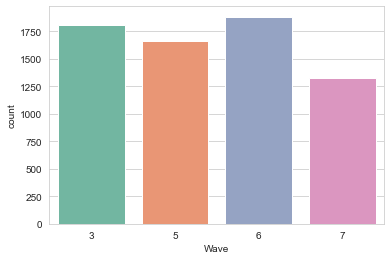

In [58]:
#Число респондентов в каждой волне.
sns.countplot(data = df_for_plot, x = 'Wave')

Данные не сбалансированны по числу респондентов в каждой волне, в 7 волне меньше всего респондентов.

<Axes: xlabel='Sex', ylabel='count'>

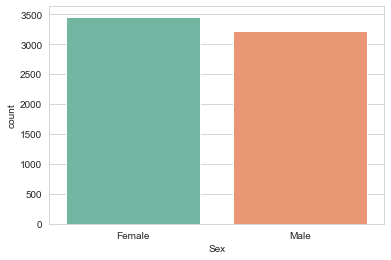

In [59]:
#Распределение ответов по полу (0 - male, 1 - female)
df_for_plot['Sex'] = df_for_plot['Sex'].replace({0: 'Male', 1: 'Female'})

sns.countplot(data=df_for_plot, x='Sex')

Среди респондентов больше женщин

<Axes: xlabel='Region', ylabel='count'>

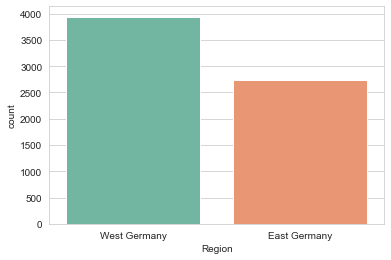

In [60]:
#Число ответов в Западной (0) и Восточной Германии (1)
df_for_plot['Region'] = df_for_plot['Region'].replace({0: 'West Germany', 1: 'East Germany'})

sns.countplot(data=df_for_plot, x='Region')

Больше ответов респондентов из регионов Западной Германии

<Axes: xlabel='Gen_trust', ylabel='count'>

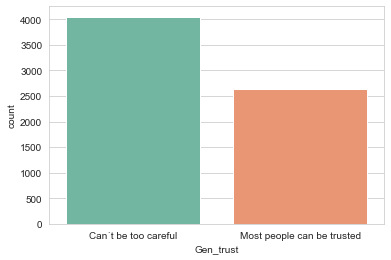

In [61]:
#Число ответов на вопрос о доверии людям (0 - не доверяю, 1 - доверяю)
df_for_plot['Gen_trust'] = df_for_plot['Gen_trust'].replace({0: 'Can´t be too careful', 1: 'Most people can be trusted'})

sns.countplot(data = df_for_plot, x = 'Gen_trust')

Большинство респондентов склонны не доверять людям

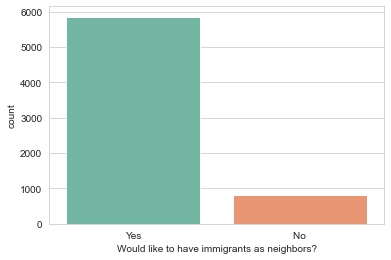

In [62]:
#Отношение к мигрантам как к соседям (0 - negative, 1 - positive)
df_for_plot['Neighbours_immigrants_attitudes'] = df_for_plot['Neighbours_immigrants_attitudes'].replace({0:'No ', 1: 'Yes'})
a = sns.countplot(data = df_for_plot, x = 'Neighbours_immigrants_attitudes')
a.set(xlabel='Would like to have immigrants as neighbors?')
plt.show()

Most people have a positive attitude to having migrant as neighbors

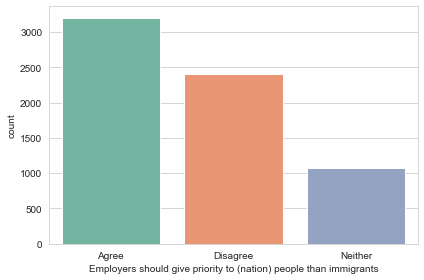

In [63]:
#Распределение ответов на вопрос "Согласны ли с утверждением, что работодатель должен давать приоритет немигрантам при приеме на работу?"
df_for_plot['Jobs_priority_to_nation'] = df_for_plot['Jobs_priority_to_nation'].replace({0: 'Disagree', 0.5: 'Neither', 1: 'Agree'})
a = sns.countplot(data=df_for_plot, x='Jobs_priority_to_nation')
a.set(xlabel='Employers should give priority to (nation) people than immigrants')
plt.tight_layout()
plt.show()

Больше респондентов согласны, что работодатель должен давать приоритет немигрантам при приеме на работу

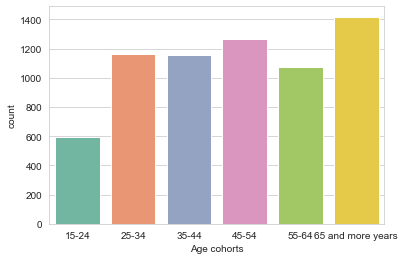

In [64]:
#Распределение респондентов по возрасту
df_for_plot['Age_group'] = df_for_plot['Age_group'].replace({1: '15-24', 2: '25-34', 3: '35-44', 4: '45-54', 5: '55-64', 6: '65 and more years'})
order = ['15-24', '25-34', '35-44', '45-54', '55-64', '65 and more years']

sns.countplot(data=df_for_plot, x='Age_group', order=order)
plt.xlabel('Age cohorts')
plt.show()

Возраст распределен не нормально, выборка скошена в сторону респондентов 65+

<Axes: xlabel='Gen_trust', ylabel='count'>

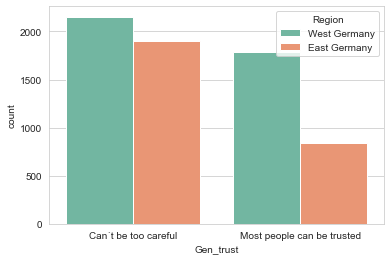

In [65]:
#Распределение доверия людям (0 - не доверяю, 1 - доверяю), разница между регионами (0 - Западная Германия, 1 - Восточная Германия)
sns.countplot(data = df_for_plot, x = 'Gen_trust', hue='Region')

In [66]:
wvs_filtered.groupby('Wave')['Gen_trust'].mean()

Wave
3    0.339978
5    0.344745
6    0.434183
7    0.471299
Name: Gen_trust, dtype: float64

<ipython-input-67-e4f7f3c8a125>:4: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x7ff52bedb250> starts with '_'. It is thus excluded from the legend.
  plt.legend(title='Region', loc='upper left', labels=['West Germany', '_nolegend_','East Germany'])


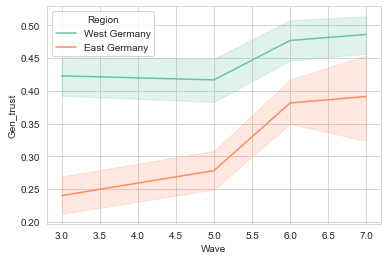

In [67]:
#Изменение доверия со временем, разница между регионами

sns.lineplot(x='Wave', y='Gen_trust', data=wvs_filtered, hue = 'Region')
plt.legend(title='Region', loc='upper left', labels=['West Germany', '_nolegend_','East Germany'])
plt.show()

Как показывает график, есть различия в том, как менялось общее доверие в Западной и Восточной Германии с 3 по 5 волны WVS. В восточной Германии доверие выросло с 3 по 5 волну, в то время как в Западной Германии немного снизилось. С 5 по 6 волну произошел рост общего доверия в обоих частях страны, и также этот рост замедлился с 6 по 7 волну.

<ipython-input-68-49e9810eb67b>:3: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x7ff549867400> starts with '_'. It is thus excluded from the legend.
  plt.legend(title='Sex', loc='upper left', labels=['Male', '_nolegend_','Female'])


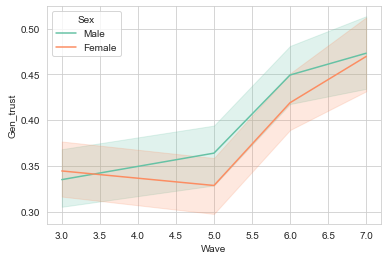

In [68]:
#Изменение доверия со временем, разница между полом
sns.lineplot(x='Wave', y='Gen_trust', data=wvs_filtered, hue='Sex')
plt.legend(title='Sex', loc='upper left', labels=['Male', '_nolegend_','Female'])
plt.show()

<ipython-input-69-bf35e12196de>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Wave', y='Gen_trust', data=df_for_plot, hue='Age_group', hue_order = ['15-24', '25-34', '35-44', '45-54', '55-64', '65 and more years'], ci=None)


<Axes: xlabel='Wave', ylabel='Gen_trust'>

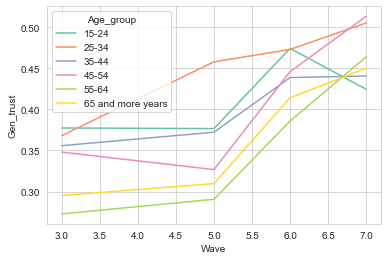

In [69]:
#Изменение доверия со временем, разница между возрастными группами
df_for_plot['Gen_trust'] = df_for_plot['Gen_trust'].replace({'Can´t be too careful': 0, 'Most people can be trusted':1})
sns.lineplot(x='Wave', y='Gen_trust', data=df_for_plot, hue='Age_group', hue_order = ['15-24', '25-34', '35-44', '45-54', '55-64', '65 and more years'], ci=None)

Общее доверие повысилось. Интересно проследить на графике, как менялось доверие возростных когорт. Например, сравнивая когорту 15-24 в WVS 3 и когорту 35-44 в WVS 7, которые по сути должны быть представлены той же группой, то за 22 года общее доверие выросло, однако устало ниже, чем у следующей возрастной когорты.

In [70]:
df_for_plot.groupby('Region')['TRUSTPOLICE'].value_counts(normalize=True) * 100

Region        TRUSTPOLICE
East Germany  0.66           57.033248
              0.33           26.306175
              1.00           11.033979
              0.00            5.626598
West Germany  0.66           60.096398
              1.00           20.624049
              0.33           16.412988
              0.00            2.866565
Name: proportion, dtype: float64

In [71]:
df_for_plot.groupby('Region')['TRUSTARMY'].value_counts(normalize=True) * 100

Region        TRUSTARMY
East Germany  0.66         42.893679
              0.33         39.349653
              0.00         11.289733
              1.00          6.466935
West Germany  0.66         50.608828
              0.33         32.217149
              0.00          8.650431
              1.00          8.523592
Name: proportion, dtype: float64

In [72]:
df_for_plot.groupby('Region')['TRUSTCOURTS'].value_counts(normalize=True) * 100

Region        TRUSTCOURTS
East Germany  0.66           41.943734
              0.33           39.057362
              0.00           11.582024
              1.00            7.416880
West Germany  0.66           51.572806
              0.33           27.803146
              1.00           16.108574
              0.00            4.515474
Name: proportion, dtype: float64

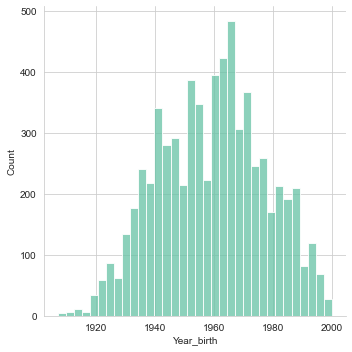

In [73]:
sns.displot(wvs_filtered, x='Year_birth')

<Axes: xlabel='Wave', ylabel='Neighbours_immigrants_attitudes'>

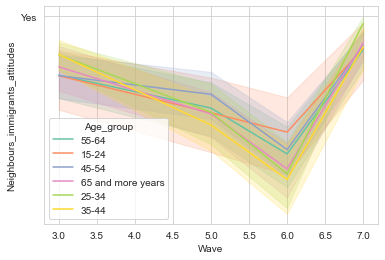

In [74]:
#Изменение отношения к мигрантам как к соседям со временем, разница между возрастными группами
sns.lineplot(x='Wave', y='Neighbours_immigrants_attitudes', data=df_for_plot, hue='Age_group')

In [75]:
#Изменение отношения к мигрантам как к соседям со временем, средние значения для каждой волны
wvs_filtered.groupby('Wave')['Neighbours_immigrants_attitudes'].mean()

Wave
3    0.928571
5    0.859459
6    0.785032
7    0.960725
Name: Neighbours_immigrants_attitudes, dtype: float64

<Axes: xlabel='Neighbours_immigrants_attitudes', ylabel='count'>

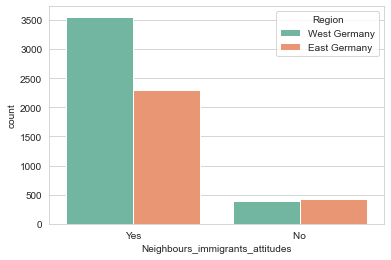

In [76]:
sns.countplot(data = df_for_plot, x = 'Neighbours_immigrants_attitudes', hue='Region')

In [77]:
df_for_plot.groupby(['Region','Neighbours_immigrants_attitudes']).count()

Wave   Edu   Sex  Age_group   
Region       Neighbours_immigrants_attitudes                                
East Germany No                                434   434   434        434  \
             Yes                              2303  2303  2303       2303   
West Germany No                                386   386   386        386   
             Yes                              3556  3556  3556       3556   

                                              Employment  Gen_trust   
Region       Neighbours_immigrants_attitudes                          
East Germany No                                      434        434  \
             Yes                                    2303       2303   
West Germany No                                      386        386   
             Yes                                    3556       3556   

                                              TRUSTARMY  TRUSTPOLICE   
Region       Neighbours_immigrants_attitudes                           
East Germany No                                     434          434  \
             Yes                                   2303         2303   
West Germany No                                     386          386   
             Yes                                   3556         3556   

                                              TRUSTCOURTS   
Region       Neighbours_immigrants_attitudes                
East Germany No                                       434  \
             Yes                                     2303   
West Germany No                                       386   
             Yes                                     3556   

                                              Jobs_priority_to_nation   
Region       Neighbours_immigrants_attitudes                            
East Germany No                                                   434  \
             Yes                                                 2303   
West Germany No                                                   386   
             Yes                                                 3556   

                                              Year_birth  
Region       Neighbours_immigrants_attitudes              
East Germany No                                      434  
             Yes                                    2303  
West Germany No                                      386  
             Yes                                    3556

In [78]:
df_for_plot.groupby(['Region','Jobs_priority_to_nation']).count()

Wave   Edu   Sex  Age_group  Employment   
Region       Jobs_priority_to_nation                                            
East Germany Agree                    1723  1723  1723       1723        1723  \
             Disagree                  606   606   606        606         606   
             Neither                   408   408   408        408         408   
West Germany Agree                    1479  1479  1479       1479        1479   
             Disagree                 1796  1796  1796       1796        1796   
             Neither                   667   667   667        667         667   

                                      Gen_trust  TRUSTARMY  TRUSTPOLICE   
Region       Jobs_priority_to_nation                                      
East Germany Agree                         1723       1723         1723  \
             Disagree                       606        606          606   
             Neither                        408        408          408   
West Germany Agree                         1479       1479         1479   
             Disagree                      1796       1796         1796   
             Neither                        667        667          667   

                                      TRUSTCOURTS   
Region       Jobs_priority_to_nation                
East Germany Agree                           1723  \
             Disagree                         606   
             Neither                          408   
West Germany Agree                           1479   
             Disagree                        1796   
             Neither                          667   

                                      Neighbours_immigrants_attitudes   
Region       Jobs_priority_to_nation                                    
East Germany Agree                                               1723  \
             Disagree                                             606   
             Neither                                              408   
West Germany Agree                                               1479   
             Disagree                                            1796   
             Neither                                              667   

                                      Year_birth  
Region       Jobs_priority_to_nation              
East Germany Agree                          1723  
             Disagree                        606  
             Neither                         408  
West Germany Agree                          1479  
             Disagree                       1796  
             Neither                         667

<Axes: xlabel='Employment', ylabel='count'>

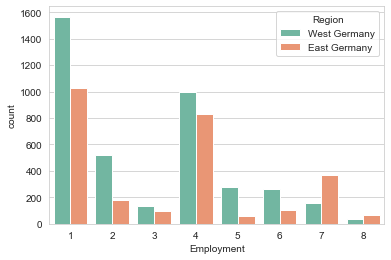

In [79]:
sns.countplot(data = df_for_plot, x = 'Employment', hue='Region')

<ipython-input-80-7b3884e56132>:4: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x7ff54983bbe0> starts with '_'. It is thus excluded from the legend.
  plt.legend(title='Region', loc='upper left', labels=['West Germany', '_nolegend_','East Germany'])


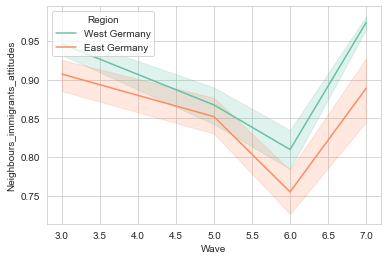

In [80]:
#Изменение отношение к мигрантам на бытовом уровне со временем, разница между регионами

sns.lineplot(x='Wave', y='Neighbours_immigrants_attitudes', data=wvs_filtered, hue = 'Region')
plt.legend(title='Region', loc='upper left', labels=['West Germany', '_nolegend_','East Germany'])
plt.show()

## 3. Correlation analysis (Are attitudes towards migrants associated with trust in Germany?)
 3.1. Check independence with chi-square test
 3.2. Cramer`s V
 3.3. Check the correlation coefficient with regression

In [81]:
sex = wvs_filtered['Sex']
edu = wvs_filtered['Edu']
region = wvs_filtered['Region']
age = wvs_filtered['Age_group']
employment = wvs_filtered['Employment']
gen_trust = wvs_filtered['Gen_trust']
army = wvs_filtered['TRUSTARMY']
police = wvs_filtered['TRUSTPOLICE']
courts = wvs_filtered['TRUSTCOURTS']
migrants = wvs_filtered['Neighbours_immigrants_attitudes']
job_priority = wvs_filtered['Jobs_priority_to_nation']

### 3.1 Chi-test

Chi-test проверяет независимость категориальных переменных.

H0: Между переменными нет статистически значимой корряляции
H1: Между переменными есть статистически значимая корряляция

Если p-value <0.05, отвергаем H0

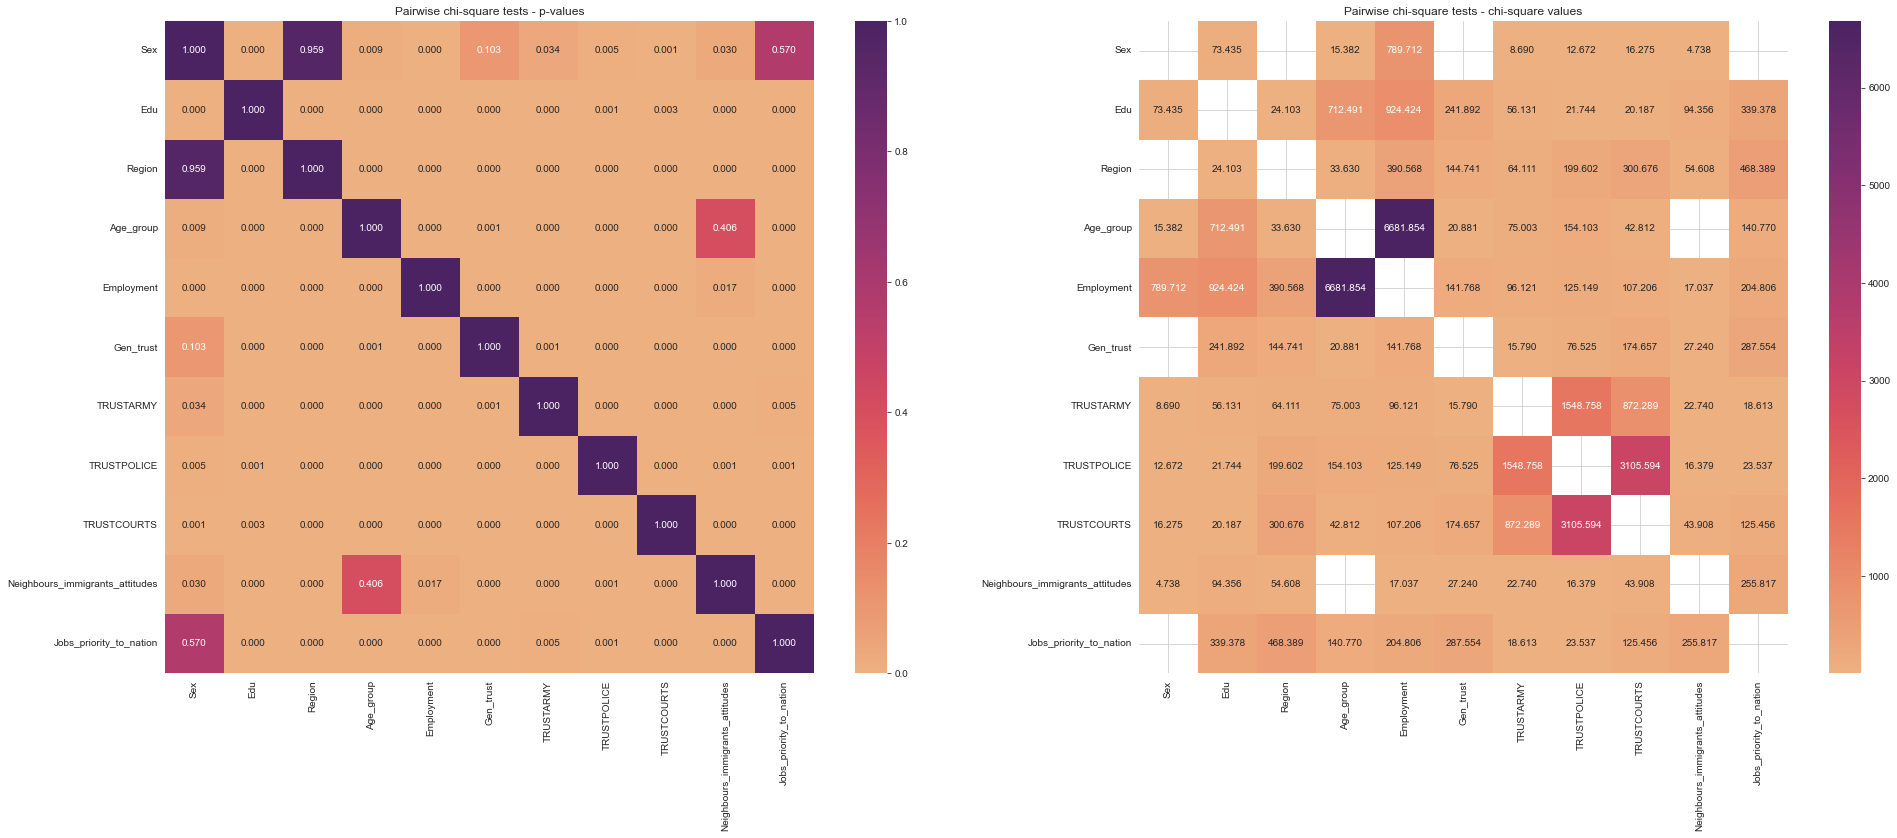

In [82]:
def pairwise_chi_square_test(sex, edu, region, age, employment, gen_trust, army, police, courts, migrants, job_priority):
    arrays = [sex, edu, region, age, employment, gen_trust, army, police, courts, migrants, job_priority]
    var_names = [a.name for a in arrays]
    chi2_values = []
    p_values = []
    for i in range(len(arrays)):
        chi2_row = []
        p_values_row = []
        for j in range(len(arrays)):
            if i == j:
                chi2_row.append(0)
                p_values_row.append(1)
            elif j < i:
                chi2_row.append(chi2_values[j][i])
                p_values_row.append(p_values[j][i])
            else:
                x = arrays[i]
                y = arrays[j]
                table = pd.crosstab(x, y)
                chi2, p, dof, expected = chi2_contingency(table.values)
                chi2_row.append(chi2)
                p_values_row.append(p)
        chi2_values.append(chi2_row)
        p_values.append(p_values_row)
    p_values_matrix = pd.DataFrame(p_values, columns=[a.name for a in arrays], index=[a.name for a in arrays])
    chi2_matrix = pd.DataFrame(chi2_values, columns=[a.name for a in arrays], index=[a.name for a in arrays])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(32, 12))
    sns.heatmap(p_values_matrix, cmap='flare', annot=True, fmt='.3f', ax=ax1, annot_kws={"size": 10})
    sns.heatmap(np.where(p_values_matrix < 0.05, chi2_matrix, np.nan), cmap='flare', annot=True, fmt='.3f', ax=ax2, annot_kws={"size": 10}, xticklabels=var_names, yticklabels=var_names)
    ax1.set_title('Pairwise chi-square tests - p-values')
    ax2.set_title('Pairwise chi-square tests - chi-square values')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


pairwise_chi_square_test(sex, edu, region, age, employment, gen_trust, army, police, courts, migrants, job_priority)

Ch2-test of Independence показал, что мы можем отвергнуть нулевую гипотезу для всех пар переменных, за исключением пар Sex-Region, Sex-Ge_trust, Sex-Jobs priority to nation и Age_group-Neighbours_immigrants_attitudes. Остальные пары переменных не являются независимыми.

In [83]:
wvs_filtered.reset_index(drop=True)

,Region,Wave,Edu,Sex,Age_group,Employment,Gen_trust,TRUSTARMY,TRUSTPOLICE,TRUSTCOURTS,Neighbours_immigrants_attitudes,Jobs_priority_to_nation,Year_birth
0,0,5,2,1,5,4,0,0.66,0.66,0.00,1,1.0,1945
1,0,5,2,1,1,6,1,0.33,0.66,0.00,1,1.0,1982
2,0,5,1,1,4,1,0,0.00,0.33,0.33,1,1.0,1957
3,0,5,1,1,6,4,0,0.66,0.66,0.66,1,1.0,1935
4,0,5,2,1,4,5,1,0.66,0.66,0.66,1,0.0,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6674,0,7,2,0,2,6,1,1.00,1.00,0.66,1,1.0,1991
6675,0,7,1,1,4,1,1,0.33,0.66,0.66,1,0.0,1965
6676,0,7,3,1,4,1,0,0.66,1.00,1.00,1,1.0,1972
6677,0,7,2,0,6,4,0,0.00,0.33,1.00,1,1.0,1938


<Axes: >

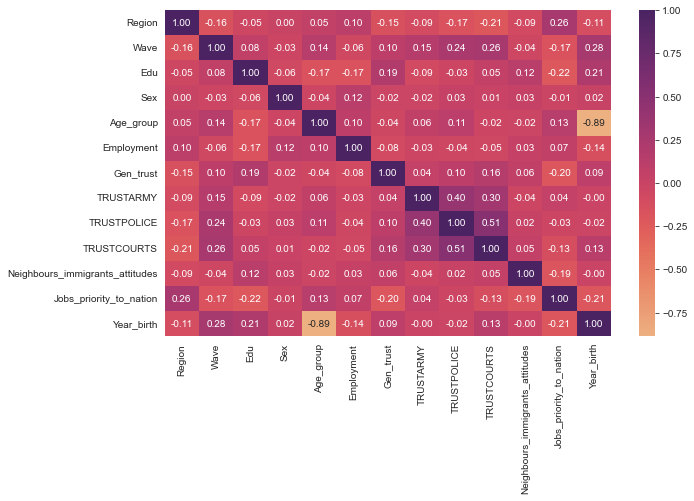

In [84]:
corr_matrix = wvs_filtered.corr()

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='flare', annot=True, fmt='.2f', ax=ax)

Переменные институционального доверия сильно коррелируют.
Общее доверие людям позитивно коррелирует с Волной опроса, образованием, Отношением к мигрантам-соседям и год рождения. Общее доверие негативно коррелирует с регионом (в Восточных регионах уровень доверия ниже), полом (мужчины доверяют меньше), трудоустройство (работающие люди меньше доверяют людям),переменные институциального доверия - доверяющие полиции, армии и судам меньше доверяют людям. Люди, поддерживающие предоставление приорите местным при приеме на работу, меньше доверяют людям. Чем моложе человек, тем больше он склонен доверять людям.

Отношение к мигрантам на бытовом уровне негативно коррелирует с регионом (в Западной Германии лучше относятся к мигрантам на бытовом уровне), Волной, доверием судам и полиции, возрастом, и согласием давать приоритет местным при приеме на работу.

Жители Восточной Германии больше поддерживают идею давать приоритет местным при приеме на работу. Чем ниже образование, тем больше люди согласны давать приоритет местным при трудоустройстве. Чем выше уровень бытового доверия, тем меньше люди согласны давать приоритет немигрантам. Чем моложе человек, тем меньше он согласен давать приоритет местным на рынке труда.

### 3.2. Cramer's V

Cramer's V показывает, насколько сильной является корреляция, где 0 - нет корреляции, 1 - сильная корреляция.

In [85]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [86]:
def pairwise_cramers_v(*arrays):
    for i in range(len(arrays)):
        for j in range(i+1, len(arrays)):
            x, y = arrays[i], arrays[j]
            v = cramers_v(x, y)
            print(f"Cramer's V for {x.name} and {y.name}")
            print(v)
            print("\n")

In [87]:
cols_to_convert = ['Region',
                   'Wave',
                   'Edu',
                   'Sex',
                   'Age_group',
                   'Employment',
                   'Gen_trust',
                   'TRUSTARMY',
                   'TRUSTPOLICE',
                   'TRUSTCOURTS',
                   'Neighbours_immigrants_attitudes',
                   'Jobs_priority_to_nation']

Cramer's V for Region and Wave
0.2620029744438512


Cramer's V for Region and Edu
0.057531003752803234


Cramer's V for Region and Sex
0.0


Cramer's V for Region and Age_group
0.0654758756450888


Cramer's V for Region and Employment
0.23966110276109445


Cramer's V for Region and Gen_trust
0.1467126354479478


Cramer's V for Region and TRUSTARMY
0.09566064761873622


Cramer's V for Region and TRUSTPOLICE
0.1715814605579036


Cramer's V for Region and TRUSTCOURTS
0.21112920441203412


Cramer's V for Region and Neighbours_immigrants_attitudes
0.08959617990812077


Cramer's V for Region and Jobs_priority_to_nation
0.2642718482166969


Cramer's V for Wave and Edu
0.17101147734804611


Cramer's V for Wave and Sex
0.03486654023700479


Cramer's V for Wave and Age_group
0.11622889036111764


Cramer's V for Wave and Employment
0.094927853631634


Cramer's V for Wave and Gen_trust
0.11073150266785207


Cramer's V for Wave and TRUSTARMY
0.10591845480344836


Cramer's V for Wave and TRUSTPOLICE

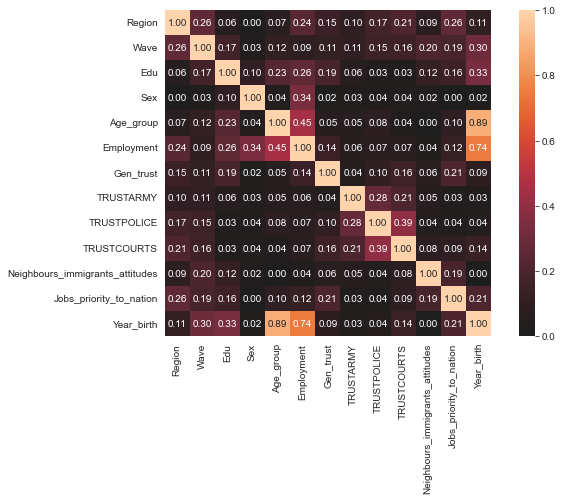

In [88]:
wvs_filtered_2[cols_to_convert] = wvs_filtered_2[cols_to_convert].astype('category')

categorical_features = identify_nominal_columns(wvs_filtered_2)

pairwise_cramers_v(*[wvs_filtered_2[feat] for feat in categorical_features])

complete_correlation = associations(wvs_filtered_2, filename='complete_correlation.png', figsize=(10,6))
df_complete_corr = complete_correlation['corr']

При интерпретации Cramer's V коэффициент k<0.20 считается слабой корреляцией, k>0.60 считается сильной корреляцией. Коэффициент корреляции переменных не превышает 0.4, для данного исследования будем считать k>0.20 достаточно сильной корреляцией, 0.10<k<0.20 - умеренной корреляцией, k<0.10 - слабой корреляцией.

Существует сильная корреляция между полом и трудоустройством, образованием и трудоустройством, регионом и трудоустройством, регионом и доверием судам, регионом и отношением к мигрантам на рынке труда, общим доверинем и отношением к мигрантам на рынке труда.

Существует умеренная корреляция между образованием и доверием, образованием и отношением к мигрантам, образованием и отношением к мигрантам на рынке труда, регионом и уровнем доверия, регионом и доверием полиции,трудоустройством и общим доверием, трудоустройством и отношением к мигрантам на рынке труда, общим доверием и отношением к мигрантам на рынке труда.

Корреляция между общим доверием (Gen_trust) и отношением к мигрантам на бытовом уровне (Neighbours_immigrants_attitudes) очень слабая (k=0.06).

### 3.3 Regression

Логистическая регрессия для зависимых переменных Neighbours_immigrants_attitudes и Jobs_priority_to_nation позволит определить коэффициент корреляции.

In [89]:
wvs_filtered_test = wvs_filtered.copy()

In [90]:
#Сначала создадим когорты из переменной Year_birth
import datetime
today = datetime.date.today()
wvs_filtered_test['age'] = today.year - wvs_filtered_test['Year_birth']

# Create bins for age cohorts
bins = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

# Create labels for age cohorts
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-110', '110-120']

# Create categorical variable 'age cohort'
wvs_filtered_test['age_cohort'] = pd.cut(wvs_filtered_test['age'], bins=bins, labels=labels)

wvs_filtered_test.sample(10)

,Region,Wave,Edu,Sex,Age_group,Employment,Gen_trust,TRUSTARMY,TRUSTPOLICE,TRUSTCOURTS,Neighbours_immigrants_attitudes,Jobs_priority_to_nation,Year_birth,age,age_cohort
125299,0,5,1,0,5,1,0,0.00,0.33,0.33,0,1.0,1950,73,70-80
132659,0,7,2,0,5,1,0,0.33,0.33,0.00,0,1.0,1959,64,60-70
130953,0,6,2,1,4,1,1,0.66,0.66,0.66,1,0.5,1962,61,60-70
132456,0,7,1,1,3,5,0,0.33,0.66,0.66,1,0.0,1973,50,40-50
127441,0,3,1,0,3,1,1,0.00,0.66,0.66,1,0.0,1961,62,60-70
127328,0,3,2,0,2,1,1,0.66,0.66,0.66,1,1.0,1971,52,50-60
129488,1,6,2,0,5,1,1,0.66,0.66,0.66,1,0.5,1955,68,60-70
128234,0,3,2,1,3,1,0,0.66,0.66,0.33,1,1.0,1960,63,60-70
128585,1,3,2,1,2,2,0,0.33,0.33,0.33,1,1.0,1969,54,50-60
132343,1,7,3,1,5,5,0,0.33,0.33,0.00,1,0.0,1955,68,60-70


<Axes: xlabel='age_cohort', ylabel='count'>

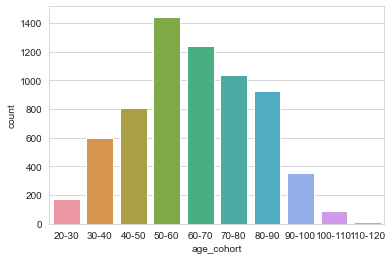

In [91]:
sns.countplot(wvs_filtered_test, x='age_cohort')

In [92]:
wvs_filtered_test = wvs_filtered_test.reset_index(drop=True)

In [93]:
#Коррелирующие переменные 'TRUSTARMY', 'TRUSTPOLICE', 'TRUSTCOURTS объединим в фактор институционального доверия
from sklearn.decomposition import FactorAnalysis

X=wvs_filtered_test[['TRUSTARMY', 'TRUSTPOLICE', 'TRUSTCOURTS']]

factor_model = FactorAnalysis(n_components=1)
X_factor = factor_model.fit_transform(X)
X_factor

array([[ 0.34119742],
       [ 0.54568982],
       [ 1.28726777],
       ...,
       [-1.51943984],
       [ 0.63362957],
       [-0.30268498]])

In [94]:
df = pd.DataFrame(X_factor, columns=['factor'])
df

,factor
0,0.341197
1,0.545690
2,1.287268
3,-0.302685
4,-0.302685
...,...
6674,-1.398432
6675,-0.098193
6676,-1.519440
6677,0.633630


In [95]:
wvs_with_factor = wvs_filtered_test.join(df)

In [96]:
wvs_with_factor_clean = wvs_filtered_test.join(df)

In [97]:
wvs_with_factor.head()

,Region,Wave,Edu,Sex,Age_group,Employment,Gen_trust,TRUSTARMY,TRUSTPOLICE,TRUSTCOURTS,Neighbours_immigrants_attitudes,Jobs_priority_to_nation,Year_birth,age,age_cohort,factor
0,0,5,2,1,5,4,0,0.66,0.66,0.00,1,1.0,1945,78,70-80,0.341197
1,0,5,2,1,1,6,1,0.33,0.66,0.00,1,1.0,1982,41,40-50,0.545690
2,0,5,1,1,4,1,0,0.00,0.33,0.33,1,1.0,1957,66,60-70,1.287268
3,0,5,1,1,6,4,0,0.66,0.66,0.66,1,1.0,1935,88,80-90,-0.302685
4,0,5,2,1,4,5,1,0.66,0.66,0.66,1,0.0,1960,63,60-70,-0.302685


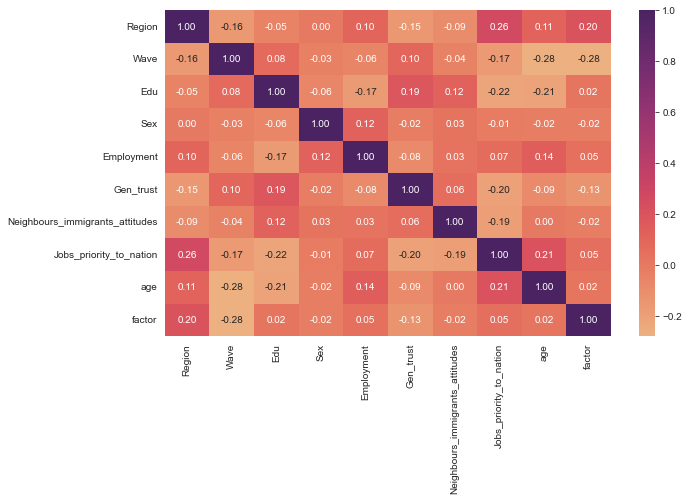

In [98]:
test_df = wvs_with_factor.drop(['age_cohort','TRUSTARMY', 'TRUSTPOLICE', 'TRUSTCOURTS', 'Year_birth', 'Age_group'] , axis=1)
corr_matrix = test_df.corr()

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='flare', annot=True, fmt='.2f', ax=ax)

plt.show()

In [99]:
wvs_with_factor_wave = wvs_with_factor.copy()

In [100]:
wvs_with_factor_wave[['Age_group', 'Employment']] = wvs_with_factor_wave[['Age_group', 'Employment']].astype('category')

In [101]:
wvs_with_factor[['Wave', 'Age_group', 'Employment']] = wvs_with_factor[['Wave', 'Age_group', 'Employment']].astype('category')

In [102]:
#Регрессия с фактором институционального доверия и переменной age_group. Переменная Wave номинальная
logreg = logit("Neighbours_immigrants_attitudes ~ Sex + Wave + Gen_trust + Region + Edu + Age_group + Employment + factor", data=wvs_with_factor).fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.340397
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Logit Regression Results                                 
===========================================================================================
Dep. Variable:     Neighbours_immigrants_attitudes   No. Observations:                 6679
Model:                                       Logit   Df Residuals:                     6658
Method:                                        MLE   Df Model:                           20
Date:                             Sun, 14 May 2023   Pseudo R-squ.:                 0.08597
Time:                                     20:15:57   Log-Likelihood:                -2273.5
converged:                                    True   LL-Null:                       -2487.4
Covariance Type:                         nonrobust   LLR p-value:                 3.625e-78
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.5588      0.214      7.286      0.000       1.140       1.978
Wave[T.5]          -0.7274      0.119     -6.120      0.000      -0.960      -0.494
Wave[T.6]          -1.3408      0.113    -11.892      0.000      -1.562      -1.120
Wave[T.7]           0.3062      0.176      1.745      0.081      -0.038       0.650
Age_group[T.2]      0.0626      0.176      0.356      0.721      -0.282       0.407
Age_group[T.3]     -0.0156      0.177     -0.088      0.930      -0.363       0.331
Age_group[T.4]      0.1796      0.177      1.014      0.311      -0.168       0.527
Age_group[T.5]      0.0508      0.188      0.271      0.787      -0.317       0.419
Age_group[T.6]     -0.0482      0.234     -0.206      0.837      -0.506       0.410
Employment[T.2]    -0.0757      0.138     -0.550      0.583      -0.346       0.194
Employment[T.3]     0.4124      0.239      1.728      0.084      -0.055       0.880
Employment[T.4]     0.3967      0.172      2.301      0.021       0.059       0.735
Employment[T.5]     0.4021      0.214      1.876      0.061      -0.018       0.822
Employment[T.6]     0.5572      0.238      2.336      0.019       0.090       1.025
Employment[T.7]     0.5337      0.158      3.367      0.001       0.223       0.844
Employment[T.8]     0.5007      0.339      1.479      0.139      -0.163       1.164
Sex                 0.1681      0.083      2.035      0.042       0.006       0.330
Gen_trust           0.3380      0.085      3.967      0.000       0.171       0.505
Region             -0.3769      0.082     -4.594      0.000      -0.538      -0.216
Edu                 0.4298      0.062      6.930      0.000       0.308       0.551
factor             -0.1182      0.046     -2.549      0.011      -0.209      -0.027
===================================================================================
"""

Регрессия с зависимой переменной Neighbours_immigrants_attitudes, с фактором институционального доверия factor и переменной age_group показала, что переменная age_group не является значимой.

In [103]:
#Добавляем intereaction effect между Wave и age_group
logreg = logit("Neighbours_immigrants_attitudes ~ Wave * Age_group + Gen_trust + Sex + Region + Edu + Employment + factor", data=wvs_with_factor).fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.339136
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Logit Regression Results                                 
===========================================================================================
Dep. Variable:     Neighbours_immigrants_attitudes   No. Observations:                 6679
Model:                                       Logit   Df Residuals:                     6643
Method:                                        MLE   Df Model:                           35
Date:                             Sun, 14 May 2023   Pseudo R-squ.:                 0.08936
Time:                                     20:15:57   Log-Likelihood:                -2265.1
converged:                                    True   LL-Null:                       -2487.4
Covariance Type:                         nonrobust   LLR p-value:                 1.985e-72
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.2157      0.322      3.775      0.000       0.585       1.847
Wave[T.5]                   -0.4669      0.368     -1.267      0.205      -1.189       0.255
Wave[T.6]                   -0.7732      0.351     -2.204      0.028      -1.461      -0.086
Wave[T.7]                    0.5226      0.543      0.963      0.336      -0.541       1.586
Age_group[T.2]               0.5241      0.349      1.500      0.134      -0.161       1.209
Age_group[T.3]               0.6589      0.369      1.785      0.074      -0.064       1.382
Age_group[T.4]               0.2953      0.359      0.824      0.410      -0.407       0.998
Age_group[T.5]               0.2483      0.378      0.657      0.511      -0.492       0.989
Age_group[T.6]               0.2871      0.420      0.684      0.494      -0.536       1.110
Employment[T.2]             -0.0723      0.138     -0.522      0.602      -0.344       0.199
Employment[T.3]              0.4218      0.239      1.766      0.077      -0.046       0.890
Employment[T.4]              0.4123      0.175      2.349      0.019       0.068       0.756
Employment[T.5]              0.4086      0.215      1.901      0.057      -0.013       0.830
Employment[T.6]              0.5506      0.238      2.314      0.021       0.084       1.017
Employment[T.7]              0.5306      0.159      3.328      0.001       0.218       0.843
Employment[T.8]              0.5054      0.341      1.484      0.138      -0.162       1.173
Wave[T.5]:Age_group[T.2]    -0.4555      0.467     -0.976      0.329      -1.371       0.460
Wave[T.6]:Age_group[T.2]    -0.8330      0.424     -1.964      0.050      -1.665      -0.002
Wave[T.7]:Age_group[T.2]     0.9997      0.915      1.092      0.275      -0.794       2.794
Wave[T.5]:Age_group[T.3]    -0.7232      0.459     -1.576      0.115      -1.622       0.176
Wave[T.6]:Age_group[T.3]    -0.9541      0.439     -2.173      0.030      -1.815      -0.094
Wave[T.7]:Age_group[T.3]    -0.5301      0.690     -0.768      0.443      -1.883       0.823
Wave[T.5]:Age_group[T.4]     0.1114      0.460      0.242      0.809      -0.790       1.013
Wave[T.6]:Age_group[T.4]    -0.3139      0.428     -0.733      0.463      -1.153       0.525
Wave[T.7]:Age_group[T.4]    -0.1488      0.647     -0.230      0.818      -1.417       1.120
Wave[T.5]:Age_group[T.5]    -0.1125      0.466     -0.241      0.809      -1.026       0.801
Wave[T.6]:Age_group[T.5]    -0.3488      0.440     -0.792      0.428      -1.212       0.514
Wave[T.7]:Age_group[T.5]    -0.2800      0.667     -0.420      0.675      -1.588       1.028
Wave[T.5]:Age_group[T.6]    -0.2149      0.468     -0.460      0.646      -1.132       0.702
Wave[T.6]:Age_group[T.6]    -0.6049      0.448     -1.350      0.177      -1.483       0.273
Wave[T.7]:Age_group[T.6]    -0.3236      0.664     -0.4

Добавление interaction effеct между Wave и Age-group также показало, что получившиеся предикторы не являются значимыми.

In [104]:
#Регрессия с фактором институционального доверия и переменной age_cohort
logreg = logit("Neighbours_immigrants_attitudes ~ Sex + Wave + Gen_trust + Region + Edu + age_cohort + Employment + factor", data=wvs_with_factor).fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.340011
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Logit Regression Results                                 
===========================================================================================
Dep. Variable:     Neighbours_immigrants_attitudes   No. Observations:                 6679
Model:                                       Logit   Df Residuals:                     6654
Method:                                        MLE   Df Model:                           24
Date:                             Sun, 14 May 2023   Pseudo R-squ.:                 0.08701
Time:                                     20:15:57   Log-Likelihood:                -2270.9
converged:                                    True   LL-Null:                       -2487.4
Covariance Type:                         nonrobust   LLR p-value:                 1.318e-76
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.9634      0.371      5.287      0.000       1.235       2.691
Wave[T.5]                -0.7452      0.121     -6.174      0.000      -0.982      -0.509
Wave[T.6]                -1.3679      0.121    -11.274      0.000      -1.606      -1.130
Wave[T.7]                 0.2646      0.183      1.445      0.149      -0.094       0.624
age_cohort[T.30-40]      -0.3026      0.340     -0.890      0.374      -0.969       0.364
age_cohort[T.40-50]      -0.4922      0.341     -1.444      0.149      -1.160       0.176
age_cohort[T.50-60]      -0.3047      0.341     -0.893      0.372      -0.974       0.364
age_cohort[T.60-70]      -0.1788      0.345     -0.518      0.604      -0.855       0.498
age_cohort[T.70-80]      -0.4030      0.355     -1.136      0.256      -1.098       0.292
age_cohort[T.80-90]      -0.3763      0.378     -0.995      0.320      -1.118       0.365
age_cohort[T.90-100]     -0.3910      0.408     -0.957      0.338      -1.192       0.410
age_cohort[T.100-110]    -0.7844      0.490     -1.602      0.109      -1.744       0.175
age_cohort[T.110-120]    -0.5435      1.130     -0.481      0.631      -2.758       1.671
Employment[T.2]          -0.0710      0.138     -0.515      0.607      -0.341       0.199
Employment[T.3]           0.4018      0.239      1.683      0.092      -0.066       0.870
Employment[T.4]           0.3899      0.158      2.469      0.014       0.080       0.699
Employment[T.5]           0.4187      0.215      1.950      0.051      -0.002       0.840
Employment[T.6]           0.4769      0.231      2.067      0.039       0.025       0.929
Employment[T.7]           0.5248      0.159      3.305      0.001       0.214       0.836
Employment[T.8]           0.4892      0.338      1.445      0.148      -0.174       1.153
Sex                       0.1650      0.083      1.993      0.046       0.003       0.327
Gen_trust                 0.3352      0.085      3.932      0.000       0.168       0.502
Region                   -0.3726      0.082     -4.539      0.000      -0.533      -0.212
Edu                       0.4293      0.062      6.892      0.000       0.307       0.551
factor                   -0.1220      0.046     -2.625      0.009      -0.213      -0.031
=========================================================================================
"""

Регрессия с фактором институционального доверия и переменной age_cohort показала, что переменная age_cohort не является значимой. Перемнная Волны является значимой для волн 5,6.  Отношение к мигрантам снижалось в 5 и 6 волну по сравнению с 3 волной, что показывают и графики. Женщины лучше относятся к соседям-мигрантам.

Общее доверие, образование и трудоустройство позитивно коррелеруют с отношением к мигрантам на бытовом уровне. Чем больше доверие людям и выше уровень образования, тем лучше отношение к мигрантам. И это корреляция довольно сильная - 0.3 для Gen_trust  0.4 для Edu. Люди, не работающие full time и part time, склонны лучше относиться к мигрантам. Регион отрицательно коррелирует с отношением к мигрантам - в Западной Германии уровень отношения к мигрантам на бытовом уровне выше. Чем больше люди доверяют институтуам, тем хуже они относятся к мигрантам на бытовом уровне.

In [105]:
#Добавляем interaction effect между Wave b age_cohort. Регрессия с фактором институционального доверия и переменной age_cohort.
logreg = logit("Neighbours_immigrants_attitudes ~ age_cohort * Wave + Gen_trust + Region + Edu + Sex + Employment + factor", data=wvs_with_factor_wave).fit()
logreg.summary()

         Current function value: 0.352221
         Iterations: 35


/Users/Sofia.Kulikova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Logit Regression Results                                 
===========================================================================================
Dep. Variable:     Neighbours_immigrants_attitudes   No. Observations:                 6679
Model:                                       Logit   Df Residuals:                     6647
Method:                                        MLE   Df Model:                           31
Date:                             Sun, 14 May 2023   Pseudo R-squ.:                 0.05422
Time:                                     20:15:58   Log-Likelihood:                -2352.5
converged:                                   False   LL-Null:                       -2487.4
Covariance Type:                         nonrobust   LLR p-value:                 6.840e-40
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -5.0215      3.998     -1.256      0.209     -12.857       2.814
age_cohort[T.30-40]            2.3415      4.118      0.569      0.570      -5.730      10.413
age_cohort[T.40-50]            5.8538      4.010      1.460      0.144      -2.006      13.713
age_cohort[T.50-60]            6.6258      4.003      1.655      0.098      -1.220      14.472
age_cohort[T.60-70]            7.1904      4.010      1.793      0.073      -0.668      15.049
age_cohort[T.70-80]            7.1248      4.011      1.776      0.076      -0.737      14.987
age_cohort[T.80-90]            6.8313      4.012      1.703      0.089      -1.033      14.695
age_cohort[T.90-100]           6.9796      4.042      1.727      0.084      -0.943      14.902
age_cohort[T.100-110]          8.6860      4.202      2.067      0.039       0.451      16.921
age_cohort[T.110-120]         57.3609   5.07e+06   1.13e-05      1.000   -9.93e+06    9.93e+06
Employment[T.2]               -0.0956      0.135     -0.706      0.480      -0.361       0.170
Employment[T.3]                0.3129      0.236      1.326      0.185      -0.150       0.776
Employment[T.4]                0.4480      0.170      2.629      0.009       0.114       0.782
Employment[T.5]                0.3638      0.213      1.710      0.087      -0.053       0.781
Employment[T.6]                0.6738      0.236      2.850      0.004       0.210       1.137
Employment[T.7]                0.5917      0.157      3.766      0.000       0.284       0.900
Employment[T.8]                0.4973      0.341      1.459      0.144      -0.171       1.165
Wave                           0.9345      0.618      1.513      0.130      -0.276       2.145
age_cohort[T.30-40]:Wave      -0.3967      0.642     -0.618      0.537      -1.655       0.862
age_cohort[T.40-50]:Wave      -0.9928      0.622     -1.597      0.110      -2.212       0.226
age_cohort[T.50-60]:Wave      -1.0864      0.620     -1.752      0.080      -2.302       0.129
age_cohort[T.60-70]:Wave      -1.1748      0.621     -1.891      0.059      -2.392       0.043
age_cohort[T.70-80]:Wave      -1.2124      0.622     -1.948      0.051      -2.432       0.008
age_cohort[T.80-90]:Wave      -1.1419      0.623     -1.834      0.067      -2.362       0.078
age_cohort[T.90-100]:Wave     -1.1747      0.630     -1.863      0.062      -2.410       0.061
age_cohort[T.100-110]:Wave    -1.6683      0.681     -2.449      0.014      -3.004      -0.333
age_cohort[T.110-120]:Wave   -17.6024   1.69e+06  -1.04e-05      1.000   -3.31e+06    3.31e+06
Gen_trust                      0.2820      0.084      3.352      0.001       0.117       0.447
Region                        -0.5707      0.081     -7.042      0.000      -0.730      -0.412
Edu                            0.5719      0.062      9.267      0.000       0.451  

Добавление interaction effеct между Wave и age_cohort также показало, что получившиеся предикторы не являются значимыми, за исключением age_cohort[100-110] и age_cohort[100-110].Wave. Однако это может быть вызвано тем, что в когорте 100-110 мало наблюдений.

**Вывод: Neighbours_immigrants_attitudes**

Регрессия с фактором институционального доверия и переменной возрастных когорт показала, что в пятую и шестую волны опроса отношение к мигрантам ухудшалось, по сравнению с третьей волной. По сравнению с самой молодой возрастной когортой, другие когорты хуже относятся к мигрантам на бытовом уровне. Женщины лучше отноятся к мигрантам на бытовом уровне. Коэффициент 0,33 предполагает, что более высокий уровень общего доверия связан с увеличением логарифмических шансов позитивного отношения к иммигрантам как к соседям. Коэффициент -0,37 указывает на то, что выходцы из Восточной Германии имеют более низкие логарифмические шансы позитивного отношения к иммигрантам как к соседям. Люди, не работающие full time и part time, склонны лучше относиться к мигрантам. Коэффициент -0.12 свидетельтсвует о том, что доверие институтам отрицательно коррелируют с отношением к мигрантам на бытовом уровне.



### Регрессия для переменной Jobs_priority_to_nation

Переменная Jobs_priority_to_nation принимает три значения (0 - Disagree, 0.5 - Neither, 1 - Agree). Объединим значения 0 - Disagree, 0.5 - Neither, чтобы сделать ответы сбалансированными.

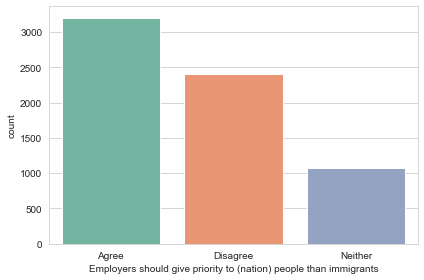

In [106]:
a = sns.countplot(data=df_for_plot, x='Jobs_priority_to_nation')
a.set(xlabel='Employers should give priority to (nation) people than immigrants')
plt.tight_layout()
plt.show()

In [107]:
wvs_with_factor_job = wvs_with_factor.copy()

In [108]:
#Меняем 0.5 - Neither на значение 0.
wvs_with_factor_job['Jobs_priority_to_nation'] = wvs_with_factor_job['Jobs_priority_to_nation'].replace({0.5 : 0})

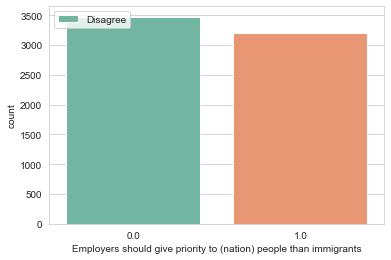

In [109]:
a = sns.countplot(data=wvs_with_factor_job, x='Jobs_priority_to_nation')
a.set(xlabel='Employers should give priority to (nation) people than immigrants')
plt.legend(loc='upper left', labels=['Disagree', '_nolegend_', 'Agree'])
plt.show()

In [110]:
#Регрессия с фактором институционального доверия и переменной age_group. Переменная Wave номинальная
logreg = logit("Jobs_priority_to_nation ~ Wave + Sex + Gen_trust + Region + Edu + Age_group + Employment + factor", data=wvs_with_factor_job).fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.609975
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                             
===================================================================================
Dep. Variable:     Jobs_priority_to_nation   No. Observations:                 6679
Model:                               Logit   Df Residuals:                     6658
Method:                                MLE   Df Model:                           20
Date:                     Sun, 14 May 2023   Pseudo R-squ.:                  0.1189
Time:                             20:15:58   Log-Likelihood:                -4074.0
converged:                            True   LL-Null:                       -4623.9
Covariance Type:                 nonrobust   LLR p-value:                2.072e-220
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9989      0.146      6.827      0.000       0.712       1.286
Wave[T.5]          -0.2270      0.075     -3.014      0.003      -0.375      -0.079
Wave[T.6]          -0.7185      0.075     -9.644      0.000      -0.865      -0.573
Wave[T.7]          -1.0294      0.087    -11.865      0.000      -1.199      -0.859
Age_group[T.2]     -0.1455      0.121     -1.202      0.229      -0.383       0.092
Age_group[T.3]      0.2037      0.125      1.629      0.103      -0.041       0.449
Age_group[T.4]      0.1032      0.124      0.832      0.406      -0.140       0.346
Age_group[T.5]      0.2481      0.133      1.865      0.062      -0.013       0.509
Age_group[T.6]      0.4966      0.165      3.017      0.003       0.174       0.819
Employment[T.2]     0.1271      0.096      1.322      0.186      -0.061       0.316
Employment[T.3]    -0.0609      0.150     -0.406      0.685      -0.355       0.233
Employment[T.4]     0.0124      0.119      0.104      0.917      -0.221       0.245
Employment[T.5]     0.1237      0.130      0.951      0.342      -0.131       0.379
Employment[T.6]    -0.4326      0.149     -2.910      0.004      -0.724      -0.141
Employment[T.7]     0.0048      0.106      0.046      0.964      -0.203       0.213
Employment[T.8]     0.4176      0.228      1.833      0.067      -0.029       0.864
Sex                -0.1619      0.057     -2.828      0.005      -0.274      -0.050
Gen_trust          -0.6051      0.056    -10.782      0.000      -0.715      -0.495
Region              0.8723      0.058     14.971      0.000       0.758       0.987
Edu                -0.4345      0.041    -10.607      0.000      -0.515      -0.354
factor             -0.0616      0.033     -1.876      0.061      -0.126       0.003
===================================================================================
"""

Результаты показывают, что при неизменности всех остальных переменных вероятность согласия с утверждением "Работодатели должны отдавать приоритет людям (нации), а не иммигрантам" уменьшается с повышением уровня образования (Edu). Кроме того, шансы согласиться с утверждением снижаются с повышением уровня общего доверия (Gun_trust) и увеличиваются с Восточной Германией (регион). Шансы согласиться с этим утверждением также снижаются для старших возрастных групп (Age_group[T.2]-Age_group[T.6]). Шансы согласиться с этим утверждением ниже у женщин (пол=-0,1232), но этот эффект не является статистически значимым при уровне значимости 0,05.
Влияние статуса занятости (Employment) и доверия военнослужащих (factor) статистически не значимо.

In [111]:
#Добавим interaction effect. Регрессия с фактором институционального доверия и переменной age_group. Переменная Wave номинальная
logreg = logit("Jobs_priority_to_nation ~ Wave * Age_group + Sex + Gen_trust + Region + Edu + Employment + factor", data=wvs_with_factor_job).fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.607321
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                             
===================================================================================
Dep. Variable:     Jobs_priority_to_nation   No. Observations:                 6679
Model:                               Logit   Df Residuals:                     6643
Method:                                MLE   Df Model:                           35
Date:                     Sun, 14 May 2023   Pseudo R-squ.:                  0.1227
Time:                             20:15:58   Log-Likelihood:                -4056.3
converged:                            True   LL-Null:                       -4623.9
Covariance Type:                 nonrobust   LLR p-value:                1.067e-215
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.0312      0.203      5.078      0.000       0.633       1.429
Wave[T.5]                   -0.0564      0.241     -0.234      0.815      -0.528       0.415
Wave[T.6]                   -0.6224      0.238     -2.619      0.009      -1.088      -0.157
Wave[T.7]                   -1.6692      0.332     -5.021      0.000      -2.321      -1.018
Age_group[T.2]              -0.2001      0.201     -0.998      0.318      -0.593       0.193
Age_group[T.3]               0.1835      0.211      0.870      0.384      -0.230       0.597
Age_group[T.4]               0.0835      0.219      0.382      0.703      -0.345       0.512
Age_group[T.5]               0.2629      0.235      1.119      0.263      -0.198       0.723
Age_group[T.6]               0.7546      0.265      2.845      0.004       0.235       1.274
Employment[T.2]              0.1260      0.097      1.301      0.193      -0.064       0.316
Employment[T.3]             -0.0675      0.151     -0.449      0.654      -0.363       0.227
Employment[T.4]              0.0049      0.122      0.041      0.968      -0.233       0.243
Employment[T.5]              0.1175      0.131      0.900      0.368      -0.138       0.373
Employment[T.6]             -0.4193      0.150     -2.787      0.005      -0.714      -0.124
Employment[T.7]              0.0013      0.107      0.012      0.991      -0.209       0.211
Employment[T.8]              0.4019      0.230      1.749      0.080      -0.048       0.852
Wave[T.5]:Age_group[T.2]    -0.2287      0.301     -0.761      0.447      -0.818       0.361
Wave[T.6]:Age_group[T.2]     0.1370      0.285      0.481      0.630      -0.421       0.695
Wave[T.7]:Age_group[T.2]     0.7335      0.391      1.874      0.061      -0.034       1.500
Wave[T.5]:Age_group[T.3]     0.0058      0.290      0.020      0.984      -0.564       0.575
Wave[T.6]:Age_group[T.3]    -0.0337      0.289     -0.116      0.907      -0.600       0.533
Wave[T.7]:Age_group[T.3]     0.3104      0.396      0.783      0.434      -0.466       1.087
Wave[T.5]:Age_group[T.4]    -0.1744      0.297     -0.588      0.556      -0.756       0.407
Wave[T.6]:Age_group[T.4]     0.0379      0.289      0.131      0.896      -0.529       0.605
Wave[T.7]:Age_group[T.4]     0.5544      0.382      1.452      0.146      -0.194       1.303
Wave[T.5]:Age_group[T.5]    -0.0884      0.308     -0.287      0.774      -0.691       0.514
Wave[T.6]:Age_group[T.5]    -0.3862      0.300     -1.286      0.198      -0.975       0.202
Wave[T.7]:Age_group[T.5]     0.9509      0.391      2.435      0.015       0.185       1.716
Wave[T.5]:Age_group[T.6]    -0.5982      0.307     -1.947      0.052      -1.201       0.004
Wave[T.6]:Age_group[T.6]    -0.4163      0.303     -1.372      0.170      -1.011       0.178
Wave[T.7]:Age_group[T.6]     0.5456      0.387      1.409      0.159      -0.214       1.305
Sex                         -0.172

In [112]:
logreg = logit("Jobs_priority_to_nation ~ Wave + Sex + Gen_trust + Region + Edu + age_cohort + Employment + factor", data=wvs_with_factor_job).fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.608950
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                             
===================================================================================
Dep. Variable:     Jobs_priority_to_nation   No. Observations:                 6679
Model:                               Logit   Df Residuals:                     6654
Method:                                MLE   Df Model:                           24
Date:                     Sun, 14 May 2023   Pseudo R-squ.:                  0.1204
Time:                             20:15:58   Log-Likelihood:                -4067.2
converged:                            True   LL-Null:                       -4623.9
Covariance Type:                 nonrobust   LLR p-value:                6.966e-220
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5092      0.233      2.188      0.029       0.053       0.965
Wave[T.5]                -0.1190      0.077     -1.552      0.121      -0.269       0.031
Wave[T.6]                -0.5432      0.080     -6.788      0.000      -0.700      -0.386
Wave[T.7]                -0.8041      0.093     -8.639      0.000      -0.987      -0.622
age_cohort[T.30-40]       0.4007      0.215      1.860      0.063      -0.021       0.823
age_cohort[T.40-50]       0.2730      0.214      1.274      0.203      -0.147       0.693
age_cohort[T.50-60]       0.3719      0.213      1.743      0.081      -0.046       0.790
age_cohort[T.60-70]       0.6301      0.216      2.918      0.004       0.207       1.053
age_cohort[T.70-80]       0.5415      0.225      2.412      0.016       0.101       0.982
age_cohort[T.80-90]       0.6750      0.240      2.808      0.005       0.204       1.146
age_cohort[T.90-100]      1.0150      0.267      3.801      0.000       0.492       1.538
age_cohort[T.100-110]     1.6123      0.374      4.310      0.000       0.879       2.346
age_cohort[T.110-120]     1.1483      0.756      1.519      0.129      -0.333       2.630
Employment[T.2]           0.1418      0.096      1.475      0.140      -0.047       0.330
Employment[T.3]          -0.0491      0.150     -0.327      0.743      -0.343       0.245
Employment[T.4]           0.0624      0.107      0.583      0.560      -0.148       0.273
Employment[T.5]           0.1405      0.130      1.084      0.278      -0.113       0.395
Employment[T.6]          -0.3758      0.141     -2.672      0.008      -0.652      -0.100
Employment[T.7]           0.0065      0.106      0.061      0.951      -0.201       0.214
Employment[T.8]           0.4203      0.227      1.852      0.064      -0.025       0.865
Sex                      -0.1709      0.057     -2.977      0.003      -0.283      -0.058
Gen_trust                -0.6040      0.056    -10.756      0.000      -0.714      -0.494
Region                    0.8764      0.058     15.014      0.000       0.762       0.991
Edu                      -0.4300      0.041    -10.459      0.000      -0.511      -0.349
factor                   -0.0555      0.033     -1.683      0.092      -0.120       0.009
=========================================================================================
"""

Модель исследует взаимосвязь между приоритетом рабочих мест для граждан страны и несколькими независимыми переменными. Переменная результата, jobs_priority_to_nation, является двоичной переменной, указывающей, считают ли люди, что приоритет в трудоустройстве должен быть отдан гражданам их страны.

Результаты показывают, что существует статистически значимая взаимосвязь между переменной результата и несколькими независимыми переменными, включая волну, возрастную когорту, пол, общее доверие, регион и образование. В частности, результаты показывают, что респонденты на более поздних этапах исследования с меньшей вероятностью отдают предпочтение работе для граждан. Более того, люди в возрастных группах от 30 до 110 лет с большей вероятностью отдают предпочтение работе для граждан, чем люди из контрольной возрастной группы. Мужчины с меньшей вероятностью отдают предпочтение работе для граждан, чем женщины. Респонденты, которые имеют более высокий уровень доверия к другим, с меньшей вероятностью отдают предпочтение работе для граждан. Люди, которые живут в определенных регионах, с большей вероятностью отдают предпочтение работе для граждан, чем те, кто живет в других регионах. Наконец, респонденты с более высоким уровнем образования менее склонны отдавать предпочтение работе для граждан, чем респонденты с более низким уровнем образования.
Однако влияние некоторых переменных несущественно. Переменная занятость не оказывает существенного влияния на переменную результата, указывая на то, что статус занятости не связан с приоритетом рабочих мест для страны. Кроме того, переменный фактор оказывает погранично значимый эффект, указывая на то, что он может оказывать или не оказывать влияние на переменную результата.

### Мультиномиальная регрессия для Jobs_priority_to_nation

In [113]:
wvs_with_factor.head(20)

,Region,Wave,Edu,Sex,Age_group,Employment,Gen_trust,TRUSTARMY,TRUSTPOLICE,TRUSTCOURTS,Neighbours_immigrants_attitudes,Jobs_priority_to_nation,Year_birth,age,age_cohort,factor
0,0,5,2,1,5,4,0,0.66,0.66,0.00,1,1.0,1945,78,70-80,0.341197
1,0,5,2,1,1,6,1,0.33,0.66,0.00,1,1.0,1982,41,40-50,0.545690
2,0,5,1,1,4,1,0,0.00,0.33,0.33,1,1.0,1957,66,60-70,1.287268
3,0,5,1,1,6,4,0,0.66,0.66,0.66,1,1.0,1935,88,80-90,-0.302685
4,0,5,2,1,4,5,1,0.66,0.66,0.66,1,0.0,1960,63,60-70,-0.302685
5,0,5,2,0,4,7,1,0.33,0.33,0.66,1,1.0,1958,65,60-70,0.760834
6,0,5,3,0,6,4,1,0.66,0.66,0.66,1,0.5,1933,90,80-90,-0.302685
7,0,5,3,0,6,4,0,0.33,0.66,0.66,1,1.0,1932,91,90-100,-0.098193
8,0,5,3,0,5,1,0,0.33,0.33,0.33,1,0.0,1948,75,70-80,1.082775
9,0,5,2,1,6,4,0,0.33,0.66,0.66,1,1.0,1937,86,80-90,-0.098193


In [114]:
#Dummy variables для категориальных переменных
prefixes = {
    'Region': 'reg_',
    'Wave' : 'wave_',
    'Edu': 'edu_',
    'Sex': 'sex_',
    'age_cohort': 'cohort_',
    'Employment': 'empl_',
    'Gen_trust': 'trust_'
}

In [115]:
wvs_with_factor_job2 = wvs_with_factor.drop(['TRUSTARMY', 'TRUSTPOLICE', 'TRUSTCOURTS', 'Neighbours_immigrants_attitudes', 'age', 'Year_birth', 'age_cohort'], axis =1)

In [116]:
wvs_with_factor_job2.head()

,Region,Wave,Edu,Sex,Age_group,Employment,Gen_trust,Jobs_priority_to_nation,factor
0,0,5,2,1,5,4,0,1.0,0.341197
1,0,5,2,1,1,6,1,1.0,0.545690
2,0,5,1,1,4,1,0,1.0,1.287268
3,0,5,1,1,6,4,0,1.0,-0.302685
4,0,5,2,1,4,5,1,0.0,-0.302685


In [118]:
wvs_filtered_dummies = pd.get_dummies(wvs_with_factor_job2, prefix=prefixes, prefix_sep='',columns=list(prefixes.keys()))
wvs_filtered_dummies.head()

KeyError: "['age_cohort'] not in index"

In [120]:
wvs_with_factor_job2['Jobs_priority_to_nation'] = wvs_with_factor_job2['Jobs_priority_to_nation'].replace({0.5:1, 1:2})

In [121]:
import statsmodels.api as sm

X = wvs_with_factor_job2.drop(columns=['Jobs_priority_to_nation'])
y = wvs_with_factor_job2['Jobs_priority_to_nation']

X = X.astype(float)

model = sm.MNLogit(y, X)
results = model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.598376
         Iterations 5
                             MNLogit Regression Results                            
Dep. Variable:     Jobs_priority_to_nation   No. Observations:                 6679
Model:                             MNLogit   Df Residuals:                     6671
Method:                                MLE   Df Model:                            7
Date:                     Sun, 14 May 2023   Pseudo R-squ.:                 0.08394
Time:                             20:16:23   Log-Likelihood:                -3996.6
converged:                            True   LL-Null:                       -4362.8
Covariance Type:                 nonrobust   LLR p-value:                6.968e-154
Jobs_priority_to_nation=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Region                        1.0880  

In [122]:
wvs_with_factor_job3 = wvs_with_factor.drop(['TRUSTARMY', 'TRUSTPOLICE', 'TRUSTCOURTS', 'Neighbours_immigrants_attitudes', 'age', 'Year_birth', 'Age_group'], axis =1)

In [123]:
wvs_with_factor_job3['age_cohort']=wvs_with_factor_job3['age_cohort'].replace({'70-80': 6, '40-50': 3, '60-70': 5, '80-90': 7, '90-100': 8, '50-60': 4, '100-110': 9, '30-40': 2, '110-120': 10, '20-30': 1})

In [124]:
wvs_with_factor_job3['Jobs_priority_to_nation'] = wvs_with_factor_job3['Jobs_priority_to_nation'].replace({0.5:1, 1:2})

In [125]:
X = wvs_with_factor_job3.drop(columns=['Jobs_priority_to_nation'])
y = wvs_with_factor_job3['Jobs_priority_to_nation']

X = X.astype(float)

model = sm.MNLogit(y, X)
results = model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.933673
         Iterations 5
                             MNLogit Regression Results                            
Dep. Variable:     Jobs_priority_to_nation   No. Observations:                 6679
Model:                             MNLogit   Df Residuals:                     6663
Method:                                MLE   Df Model:                           14
Date:                     Sun, 14 May 2023   Pseudo R-squ.:                 0.07944
Time:                             20:16:23   Log-Likelihood:                -6236.0
converged:                            True   LL-Null:                       -6774.2
Covariance Type:                 nonrobust   LLR p-value:                6.419e-221
Jobs_priority_to_nation=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Region                        0.5853  

Сравнивая Jobs_priority_to_nation = 2 с референсной категорией, используем Процентное изменение = (exp(coef) - 1) * 100

## 4. Test the stability of association with plots

In [126]:
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [127]:
wvs_with_factor['age_cohort'] = wvs_with_factor['age_cohort'].replace(
    {'20-30': '1993-2003 (20-30)', '30-40': '1983-1992 (31-40)', '40-50': '1973-1982 (41-50)',
     '50-60': '1963-1972 (51-60)', '60-70': '1953-1962 (61-70)', '70-80': '1943-1952 (71-80)',
     '80-90': '1933-1942 (81-90)', '90-100': '1923-1932 (91-100)', '100-110': '1913-1922 (101-110)',
     '110-120': '1903-1912 (111-120)'})
mask = wvs_with_factor['age_cohort'].isin(['1913-1922 (101-110)', '1903-1912 (111-120)', '1993-2003 (20-30)'])

wvs_filtered_cohorts = wvs_with_factor.loc[~mask]

In [128]:
wvs_filtered_cohorts['Region'] = wvs_filtered_cohorts['Region'].replace({0:'West Germany', 1: 'East Germany'})

In [129]:
wvs_with_factor.groupby('Region')['age_cohort'].value_counts()

Region  age_cohort         
0       1963-1972 (51-60)      947
        1953-1962 (61-70)      687
        1943-1952 (71-80)      566
        1973-1982 (41-50)      496
        1933-1942 (81-90)      466
        1983-1992 (31-40)      399
        1923-1932 (91-100)     186
        1993-2003 (20-30)      136
        1913-1922 (101-110)     52
        1903-1912 (111-120)      7
1       1953-1962 (61-70)      549
        1963-1972 (51-60)      496
        1943-1952 (71-80)      471
        1933-1942 (81-90)      458
        1973-1982 (41-50)      314
        1983-1992 (31-40)      202
        1923-1932 (91-100)     168
        1913-1922 (101-110)     39
        1993-2003 (20-30)       36
        1903-1912 (111-120)      4
Name: count, dtype: int64

In [130]:
def plot_line_graph(x, y, data, hue, title, x_label, y_label):
    plt.figure(figsize=(8, 6))
    sns.set_palette("Set2")

    ax = sns.lineplot(x=x, y=y, data=data, hue=hue, ci=None)

    ax.set_title(title, fontsize=16)  # Увеличение размера шрифта заголовка
    ax.set_xlabel(x_label, fontsize=14)  # Увеличение размера шрифта подписи оси x
    ax.set_ylabel(y_label, fontsize=14)  # Увеличение размера шрифта подписи оси y
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [131]:
def plot_facet_line_graph(data, x, y, hue, x_label, y_label, title):
    g = sns.FacetGrid(data=data, col='Region', hue=hue, palette='Set2', col_wrap=2, height=6, aspect=1)
    g.map(sns.lineplot, x, y, ci=None)

    g.set_axis_labels(x_label, y_label)
    g.fig.suptitle(title, fontsize=16)

    g.set_titles('{col_name}')
    g.add_legend()

    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45)
    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45)
        ax.xaxis.label.set_fontsize(14)  # Увеличение размера шрифта подписи оси x
        ax.yaxis.label.set_fontsize(14)  # Увеличение размера шрифта подписи оси y
        ax.title.set_fontsize(14)  # Увеличение размера шрифта заголовка подграфика

    plt.tight_layout()
    plt.show()

In [132]:
def plot_age_cohorts(data, x_col, y_col, title, x_label, y_label):
    g = sns.FacetGrid(data=data, col='Region', palette='Set2', col_wrap=2, height=6, aspect=1)
    g.map(sns.lineplot, x_col, y_col, ci=None, linewidth=2.5)
    plt.suptitle(title, fontsize=16)
    g.set_xticklabels(rotation=45)

    g.set_axis_labels(x_label, y_label)
    plt.subplots_adjust(top=0.9)

    # Обрезание графика по оси x
    min_x = data[x_col].min()
    max_x = data[x_col].max()
    for ax in g.axes.flat:
        ax.set_xlim(min_x, max_x)
    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45)
        ax.xaxis.label.set_fontsize(14)  # Увеличение размера шрифта подписи оси x
        ax.yaxis.label.set_fontsize(14)  # Увеличение размера шрифта подписи оси y
        ax.title.set_fontsize(14)  # Увеличение размера шрифта заголовка подграфика

    plt.tight_layout()
    plt.show()

In [133]:
def plot_trend(data, x, y1, y2, x_label, y_label, title, color1='green', color2='red', label1='Line 1', label2='Line 2'):
    scaler = MinMaxScaler()
    data_normalized = data.copy()
    data_normalized[[y1, y2]] = scaler.fit_transform(data_normalized[[y1, y2]])

    g = sns.FacetGrid(data=data_normalized, col='Region', palette='Set2', col_wrap=2, height=8, aspect=1)
    g.map(sns.lineplot, x, y1, ci=None, color=color1, label=label1)
    g.map(sns.lineplot, x, y2, ci=None, color=color2, label=label2)

    g.set_axis_labels(x_label, y_label)
    g.fig.suptitle(title, fontsize=16)

    g.set_titles('{col_name}')
    g.add_legend()

    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45)
        ax.xaxis.label.set_fontsize(16)  # Увеличение размера шрифта подписи оси x
        ax.yaxis.label.set_fontsize(16)  # Увеличение размера шрифта подписи оси y
        ax.title.set_fontsize(16)  # Увеличение размера шрифта заголовка подграфика

    plt.tight_layout()
    plt.show()

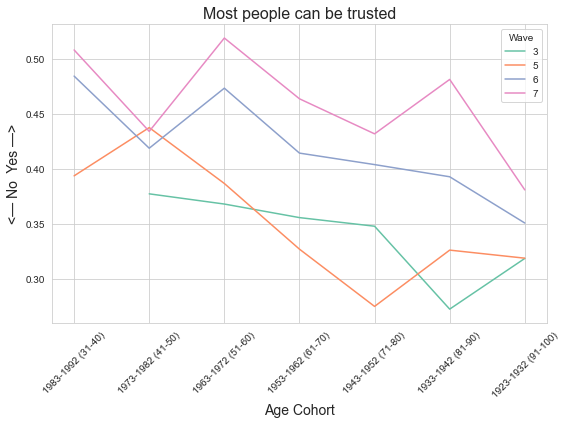

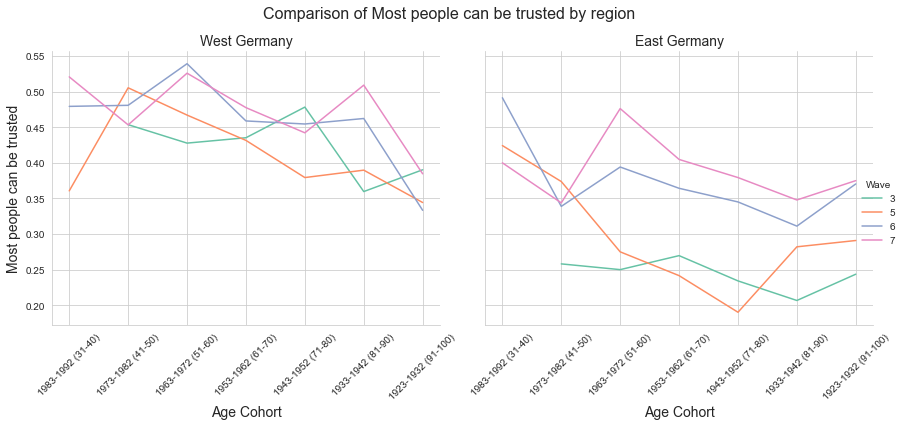

In [134]:
plot_line_graph(x='age_cohort', y='Gen_trust', data=wvs_filtered_cohorts, hue='Wave',
                title='Most people can be trusted', x_label='Age Cohort', y_label='<— No  Yes —>')

plot_facet_line_graph(data=wvs_filtered_cohorts,
                      x='age_cohort',
                      y='Gen_trust',
                      hue='Wave',
                      x_label='Age Cohort',
                      y_label='Most people can be trusted',
                      title='Comparison of Most people can be trusted by region')

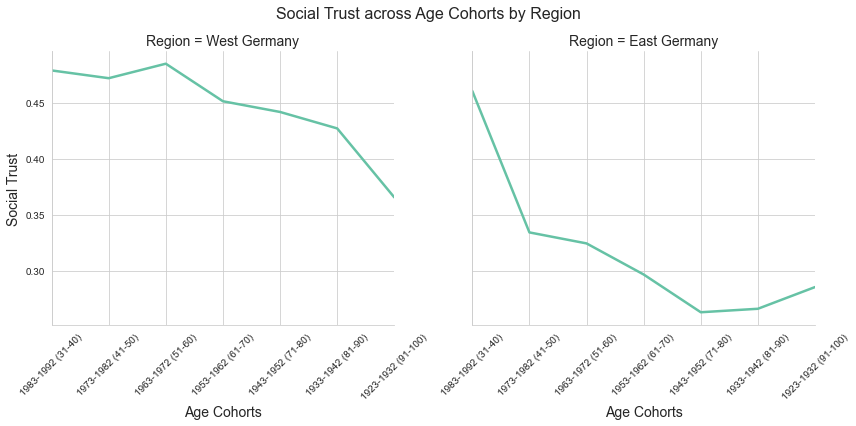

In [135]:
plot_age_cohorts(wvs_filtered_cohorts, 'age_cohort', 'Gen_trust', 'Social Trust across Age Cohorts by Region', 'Age Cohorts', 'Social Trust')

Для всех волн опроса мы видим тренд, направленный на повышение доверия к людям. Однако изменение отношения для разных когорт происходит по-разному. В том числе мы видим значительную разницу между соседними когортами. Например, когорта 1942-1933 - люди родившиеся до войны и чье детство пришлось на войну и послевоенное восстановление, в 3 волну демонстрировала очень никзий уровень доверия, однако с каждой волной доверие росло и в 7 волну оказалось даже выше, чем у других более молодых когорт. Интересно, как менялось доверие для когорт 1943-1952 и 1953-1962. Это редкий пример, когда доверие в 5 волну снизилось по сравнению с 3 волной.

Сравнивая доверие в Восточной и Западной Германии, в глаза бросается низкий уровень доверия в Восточной Германии о когорт 1923-1932, 1933-1942, 1943-1952б 1953-1962, 1963-1972 в 3 и 5 волну и резкий рост доверия у этих же когорт в 6 и 7 волны. В то же время эти же когорты в Западной Германии изначально имели достаточно высокий уровень доверия, но рост был неравномерный и не для всех когорт. Особенно отличается динамика доверия у когорты 1943-1952 - в обоих регионах доверие в 5 волну ниже чем в 3, то есть в начале 21 века люди 53-62 лет испытывали пессимизм по отношению к другим людям. Когорта 1973-1982 также разительно отличатеся в уровне доверия и динамике по сравнению с соседними когортами, и в Западной и в Восточной части страны доверие у этой когорты остается очень стабильным и, в отличие от более старших когорт, было выше всего в 5 волну опроса 2005-2009.

Поколенческий сдвиг в доверии людям присутствует в обоих частях страны, однако в Восточной Германии этот сдвиг выражен очень ярко для когорты 1983-1992 - это единственная когорта анализа, чье детство и становление пришлось на время после объединения Германии.

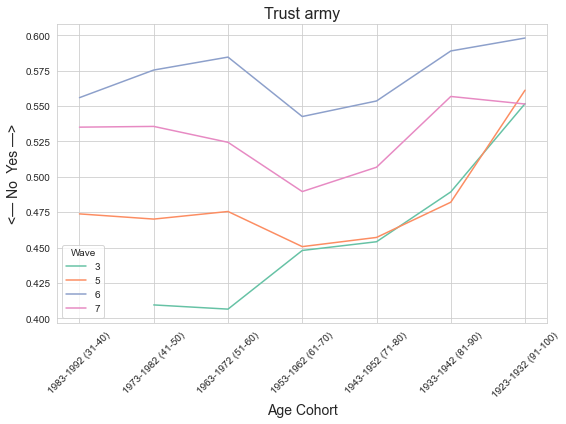

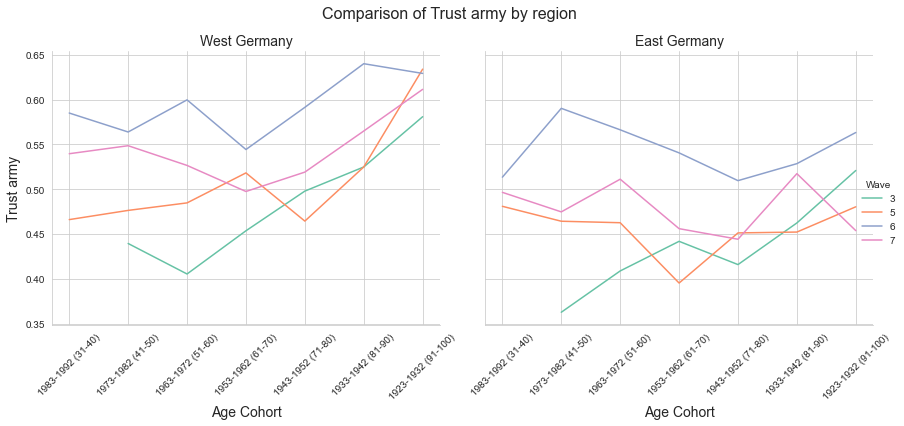

In [136]:
plot_line_graph(x='age_cohort', y='TRUSTARMY', data=wvs_filtered_cohorts, hue='Wave',
                title='Trust army', x_label='Age Cohort', y_label='<— No  Yes —>')

plot_facet_line_graph(data=wvs_filtered_cohorts,
                      x='age_cohort',
                      y='TRUSTARMY',
                      hue='Wave',
                      x_label='Age Cohort',
                      y_label='Trust army',
                      title='Comparison of Trust army by region')

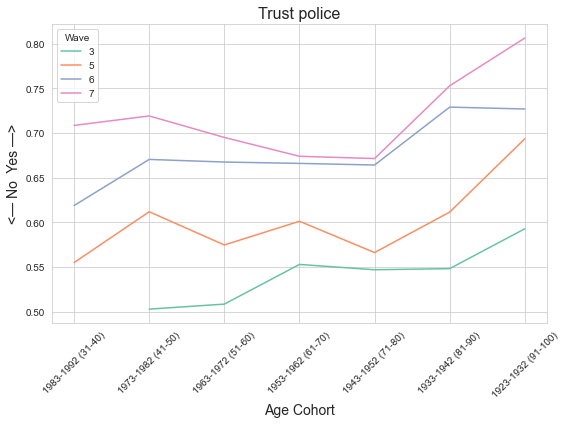

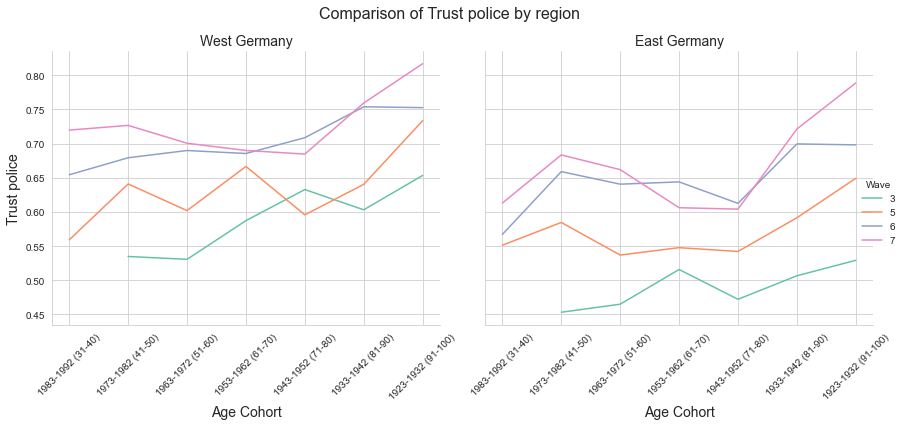

In [137]:
plot_line_graph(x='age_cohort', y='TRUSTPOLICE', data=wvs_filtered_cohorts, hue='Wave',
                title='Trust police', x_label='Age Cohort', y_label='<— No  Yes —>')

plot_facet_line_graph(data=wvs_filtered_cohorts,
                      x='age_cohort',
                      y='TRUSTPOLICE',
                      hue='Wave',
                      x_label='Age Cohort',
                      y_label='Trust police',
                      title='Comparison of Trust police by region')

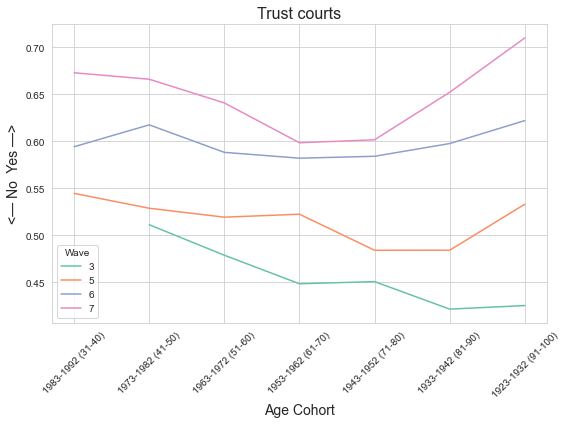

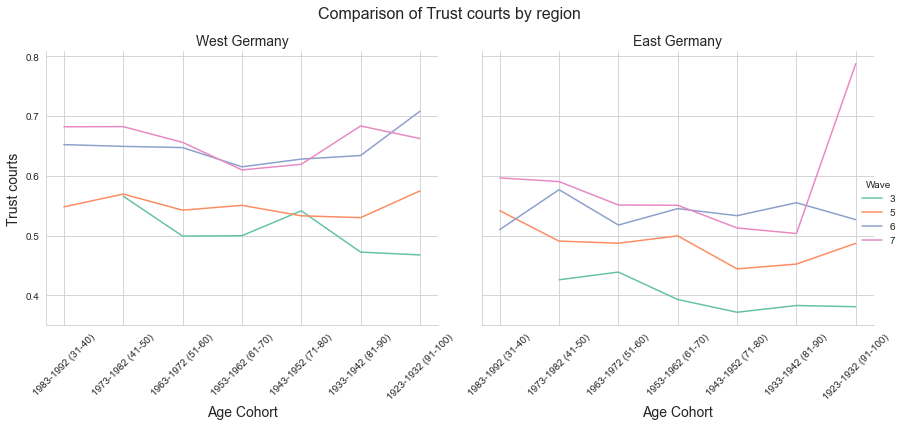

In [138]:
plot_line_graph(x='age_cohort', y='TRUSTCOURTS', data=wvs_filtered_cohorts, hue='Wave',
                title='Trust courts', x_label='Age Cohort', y_label='<— No  Yes —>')

plot_facet_line_graph(data=wvs_filtered_cohorts,
                      x='age_cohort',
                      y='TRUSTCOURTS',
                      hue='Wave',
                      x_label='Age Cohort',
                      y_label='Trust courts',
                      title='Comparison of Trust courts by region')

In [139]:
max_value = wvs_filtered_cohorts['factor'].max()
wvs_filtered_cohorts['reversed_factor'] = max_value - wvs_filtered_cohorts['factor']

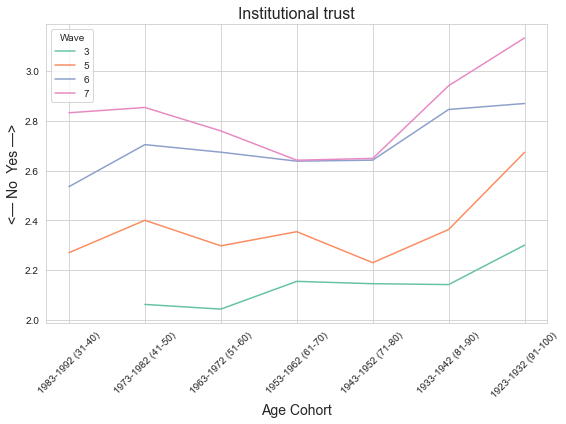

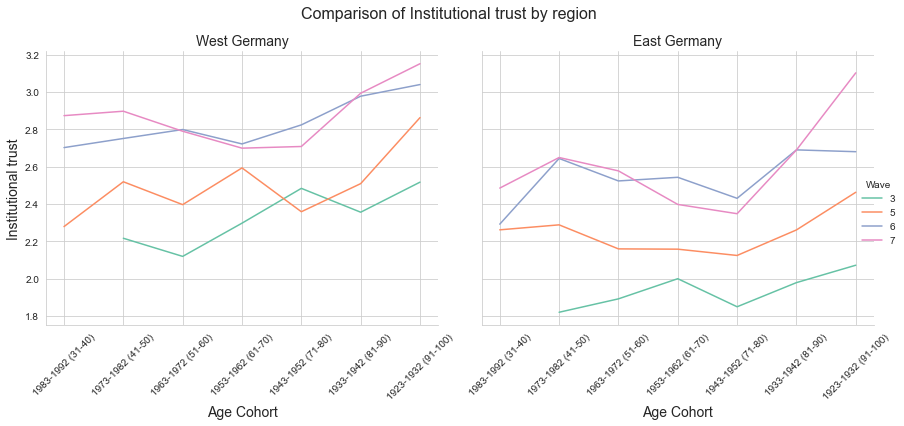

In [140]:
plot_line_graph(x='age_cohort', y='reversed_factor', data=wvs_filtered_cohorts, hue='Wave',
                title='Institutional trust', x_label='Age Cohort', y_label='<— No  Yes —>')

plot_facet_line_graph(data=wvs_filtered_cohorts,
                      x='age_cohort',
                      y='reversed_factor',
                      hue='Wave',
                      x_label='Age Cohort',
                      y_label='Institutional trust',
                      title='Comparison of Institutional trust by region')

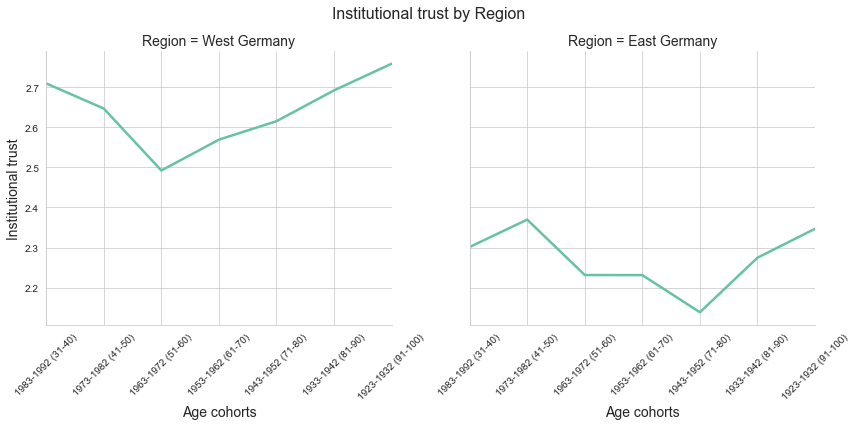

In [141]:
plot_age_cohorts(wvs_filtered_cohorts, 'age_cohort', 'reversed_factor', 'Institutional trust by Region', 'Age cohorts', 'Institutional trust')

Доверие институтам как совокупное, так и по отдельности доверие арммии, полиции и судам, в Восточной Германии остается выше, чем в Западной Германии, для всех поколений и на протяжении всех четырех волн опроса. Институциональное доверие сильно снизилось в обоих регионах, если сравнивать  3 и 7 волны опроса. Однако доверие институтам в 6 и 7 волны в целом сопоставимы.

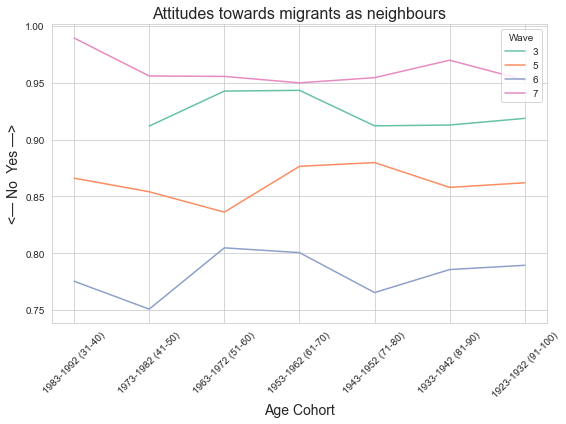

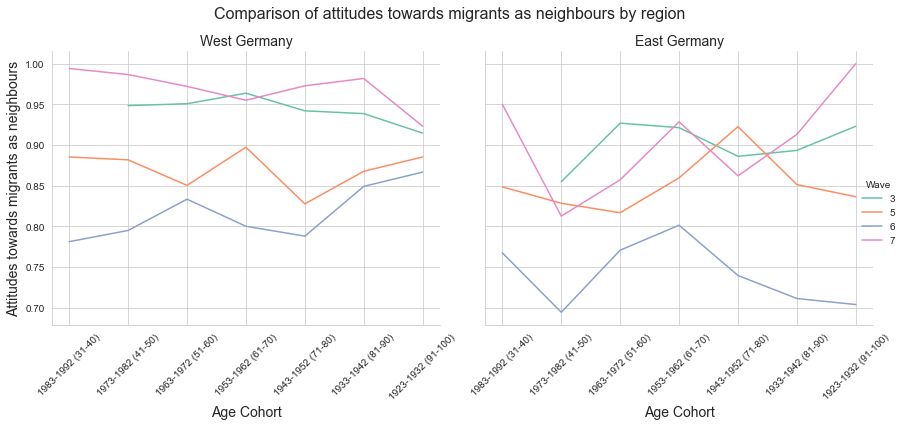

In [142]:
plot_line_graph(x='age_cohort', y='Neighbours_immigrants_attitudes', data=wvs_filtered_cohorts, hue='Wave',
                title='Attitudes towards migrants as neighbours', x_label='Age Cohort', y_label='<— No  Yes —>')

plot_facet_line_graph(data=wvs_filtered_cohorts,
                      x='age_cohort',
                      y='Neighbours_immigrants_attitudes',
                      hue='Wave',
                      x_label='Age Cohort',
                      y_label='Attitudes towards migrants as neighbours',
                      title='Comparison of attitudes towards migrants as neighbours by region')

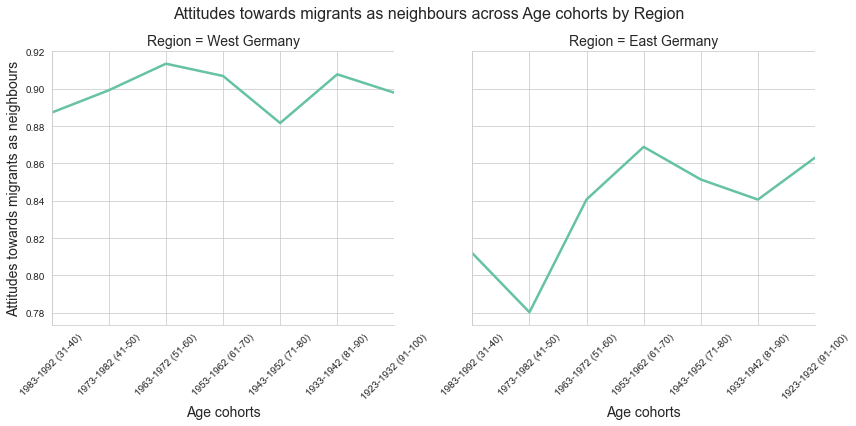

In [143]:
plot_age_cohorts(wvs_filtered_cohorts, 'age_cohort', 'Neighbours_immigrants_attitudes', 'Attitudes towards migrants as neighbours across Age cohorts by Region', 'Age cohorts', 'Attitudes towards migrants as neighbours')

In [144]:
reverse_mapping = {0: 1, 1: 0}
wvs_filtered_cohorts['reversed_jobs_priority'] = wvs_filtered_cohorts['Jobs_priority_to_nation'].map(reverse_mapping)

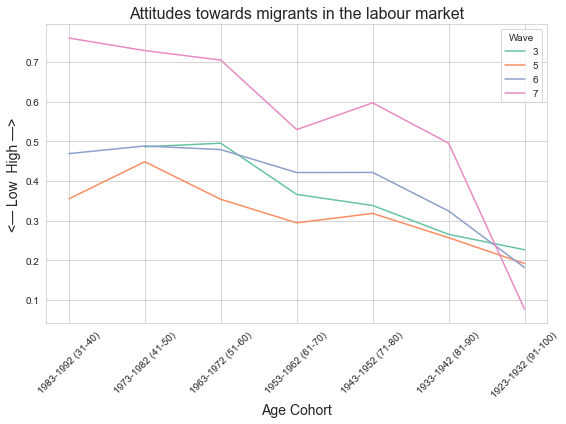

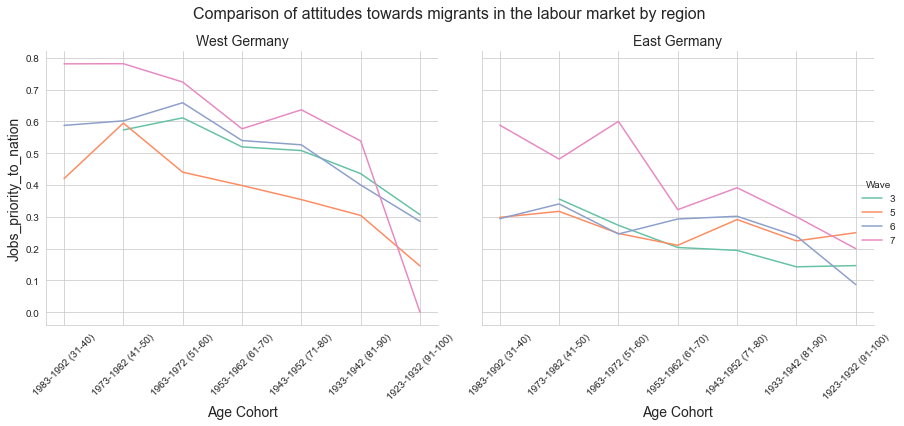

In [145]:
plot_line_graph(x='age_cohort', y='reversed_jobs_priority', data=wvs_filtered_cohorts, hue='Wave',
                title='Attitudes towards migrants in the labour market', x_label='Age Cohort', y_label='<— Low  High —>')

plot_facet_line_graph(data=wvs_filtered_cohorts,
                      x='age_cohort',
                      y='reversed_jobs_priority',
                      hue='Wave',
                      x_label='Age Cohort',
                      y_label='Jobs_priority_to_nation',
                      title='Comparison of attitudes towards migrants in the labour market by region')

Отношение к мигрантам на рынке труда постепенно улучшается и в Западной, и в Восточной Германии. Этот процесс имеет явный поколенческий эффект - более молодые поколения лучше относятся к мигрантам на рынке труда. Мы можем отнести изменение отноешния к мигрантам на рынке труда к глобальным и устойчивым сдвигам в ценностях. Учитывая кризис мигрантов в Германии в 2015 году и рост консервативных настроений, можно было бы ожидать ухудшение отношения к мигрантам в 7 волне, однако отношение улучшилось для всех когорт. Стоит отметить, что для обоих регионов характерно ухудшение отношения к мигрантам на рынке труда в 5 волну, в особенности в Западной Германии.

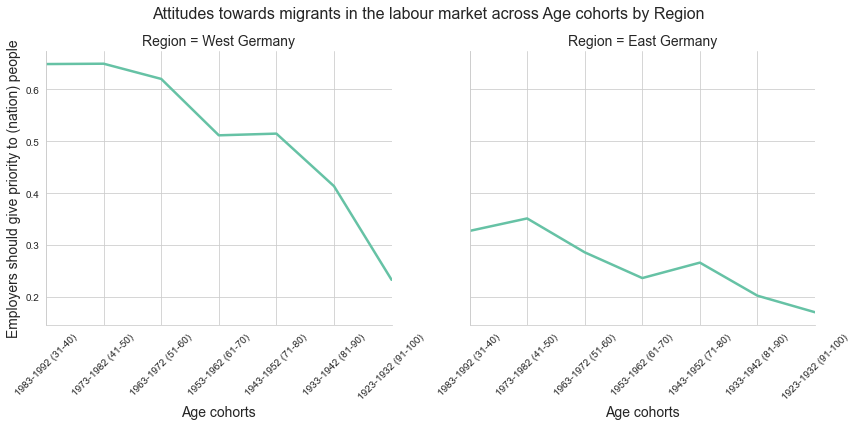

In [146]:
plot_age_cohorts(wvs_filtered_cohorts, 'age_cohort', 'reversed_jobs_priority',
                 'Attitudes towards migrants in the labour market across Age cohorts by Region', 'Age cohorts',
                 'Employers should give priority to (nation) people')

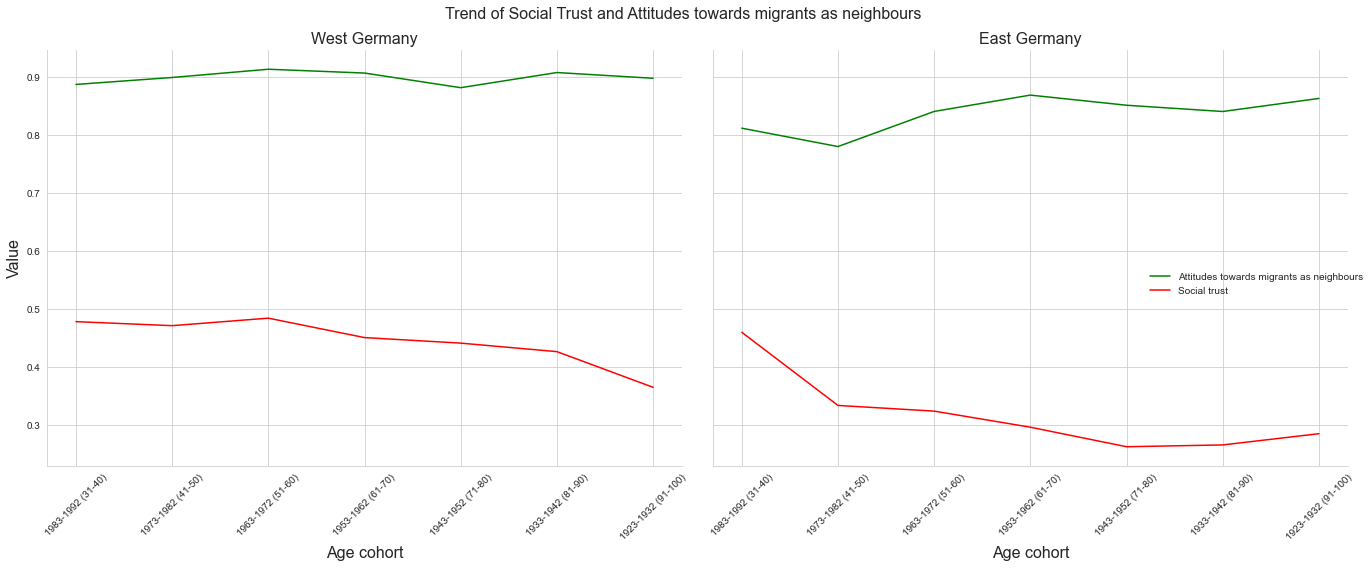

In [147]:
plot_trend(data=wvs_filtered_cohorts,
                      x='age_cohort',
                      y1='Neighbours_immigrants_attitudes',
                      y2='Gen_trust',
                      x_label='Age cohort',
                      y_label='Value',
                      title='Trend of Social Trust and Attitudes towards migrants as neighbours',
                      label1='Attitudes towards migrants as neighbours',
                      label2='Social trust')

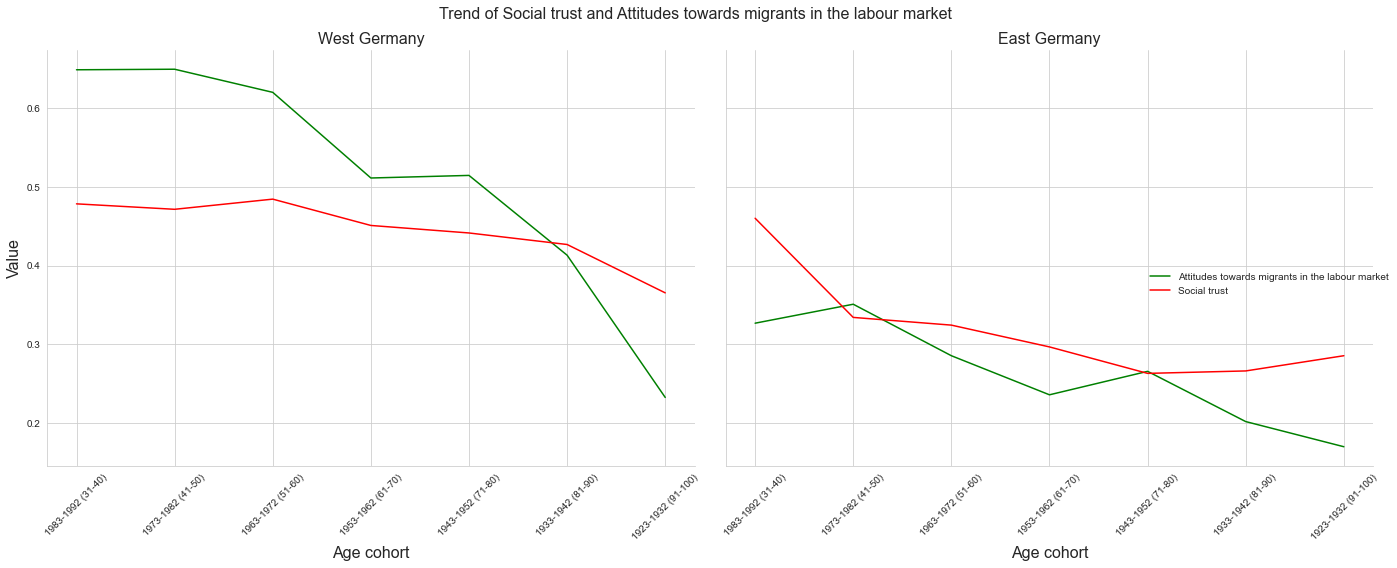

In [148]:
plot_trend(data=wvs_filtered_cohorts,
                      x='age_cohort',
                      y1='reversed_jobs_priority',
                      y2='Gen_trust',
                      x_label='Age cohort',
                      y_label='Value',
                      title='Trend of Social trust and Attitudes towards migrants in the labour market',
                      label1='Attitudes towards migrants in the labour market',
                      label2='Social trust')

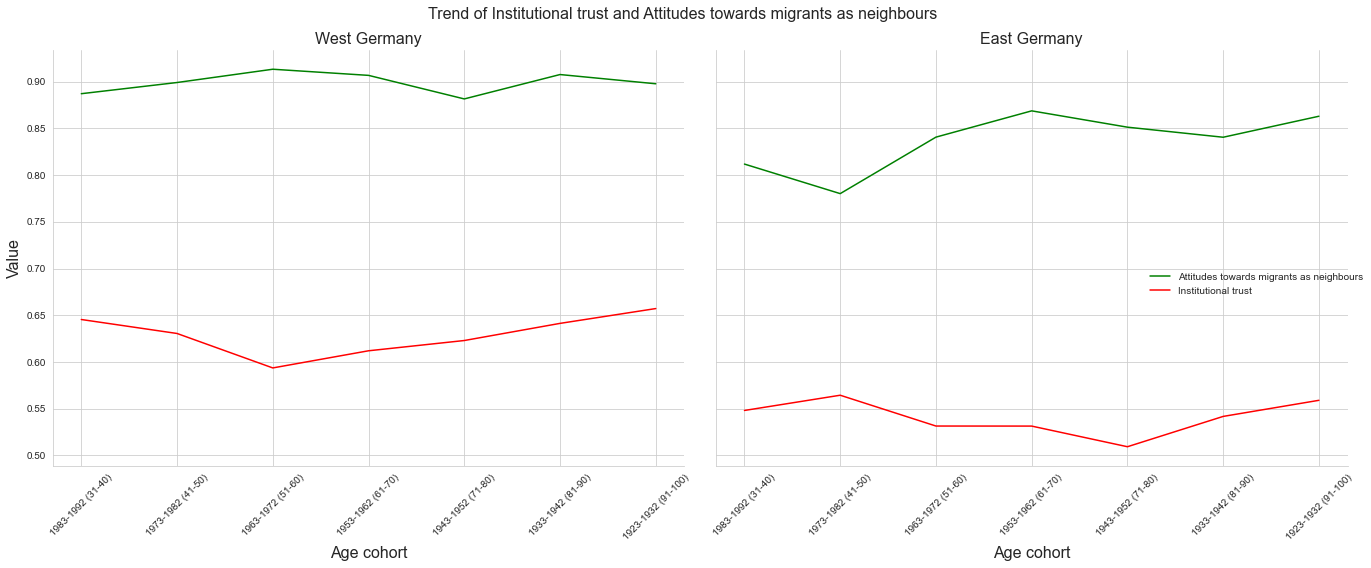

In [149]:
plot_trend(data=wvs_filtered_cohorts,
                      x='age_cohort',
                      y1='Neighbours_immigrants_attitudes',
                      y2='reversed_factor',
                      x_label='Age cohort',
                      y_label='Value',
                      title='Trend of Institutional trust and Attitudes towards migrants as neighbours',
                      label1='Attitudes towards migrants as neighbours',
                      label2='Institutional trust')

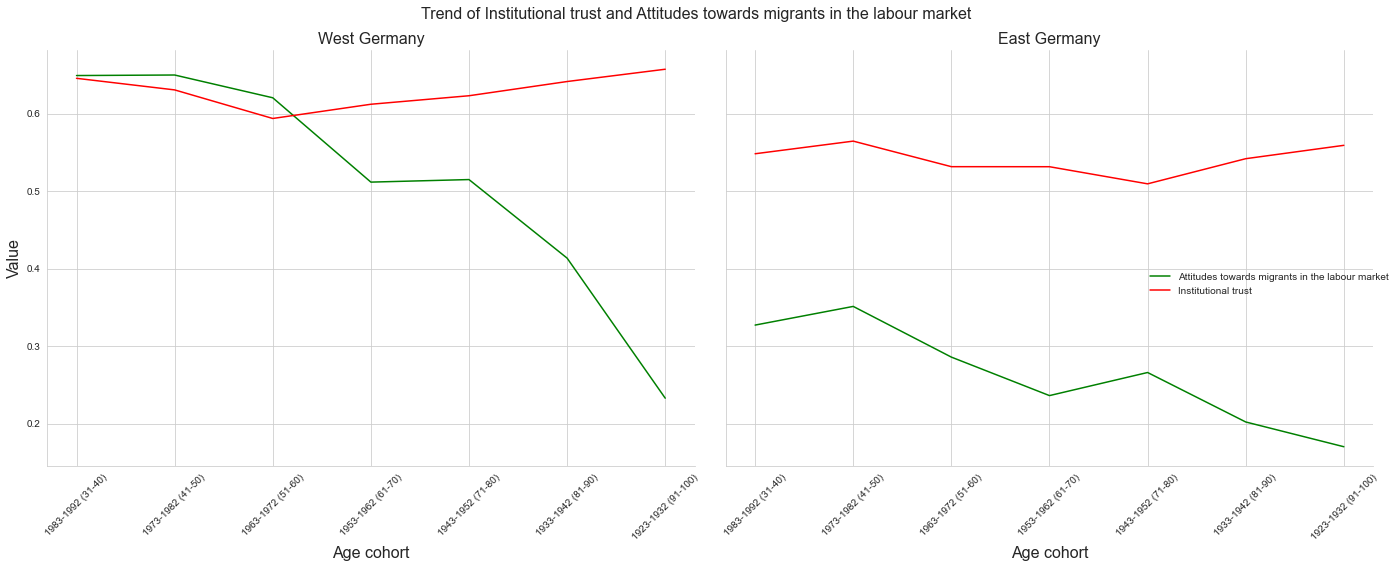

In [150]:
plot_trend(data=wvs_filtered_cohorts,
           x='age_cohort',
           y1='reversed_jobs_priority',
           y2='reversed_factor',
           x_label='Age cohort',
           y_label='Value',
           title='Trend of Institutional trust and Attitudes towards migrants in the labour market',
           label1='Attitudes towards migrants in the labour market',
           label2='Institutional trust')